In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from tqdm import tqdm

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

# With cluster diameters

In [55]:
from simulations.toric_code_bitflip_simulation import (
    load_single_simulation_data,
    get_existing_simulation_params,
    generate_toric_code,
)
from simulations.analysis.cluster_diameters import ClusterDiameterCalculator
from tqdm import tqdm

params = get_existing_simulation_params()
dlist = np.unique([p[0] for p in params])
plist = np.unique([p[1] for p in params])

diameter_calculators = {}
for d in dlist:
    H = generate_toric_code(d)[0]
    H = H.tocsc()
    diameter_calculators[d] = ClusterDiameterCalculator(H)

In [56]:
plist

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])

In [3]:
from simulations.analysis.numpy_utils import calculate_cluster_metrics_from_csr

n_jobs = 18

# Load existing stats if available
data_dir = "../../data/toric_minsum_iter30_lsd0_bitflip_raw"
stats_path = os.path.join(data_dir, "stats.pkl")

try:
    sample_stats = read_pickle(stats_path)
    print(f"Loaded existing stats from {stats_path}")
except FileNotFoundError:
    sample_stats = {}
    print("No existing stats found, starting fresh")

for d, p in tqdm(params):
    # Check if we need to process this parameter combination
    needs_processing = False

    if d not in sample_stats or p not in sample_stats[d]:
        needs_processing = True
        reason = "new parameter combination"
    else:
        # Check if shot count matches
        fails, clusters = load_single_simulation_data(d=d, p=p)
        existing_shots = len(sample_stats[d][p])
        current_shots = len(fails)

        if existing_shots != current_shots:
            needs_processing = True
            reason = f"shot count mismatch (existing: {existing_shots}, current: {current_shots})"

    if needs_processing:
        # print(f"Processing d={d}, p={p} - {reason}")
        calculator: ClusterDiameterCalculator = diameter_calculators[d]
        fails, clusters = load_single_simulation_data(d=d, p=p)

        # Calculate max diameters
        max_diameters = calculator.compute_cluster_diameters_batch(
            clusters, n_jobs=n_jobs, return_max_diameter=True
        )

        # Calculate max sizes using L∞ norm
        max_sizes, _ = calculate_cluster_metrics_from_csr(
            clusters, method="norm", norm_order=np.inf, precompile=True
        )

        # Initialize nested dictionary structure if needed
        if d not in sample_stats:
            sample_stats[d] = {}

        # Store data in dataframe format
        sample_stats[d][p] = pd.DataFrame(
            {
                "fail": fails,
                "cluster_max_diameter": max_diameters,
                "cluster_max_size": max_sizes,
            }
        )

        write_pickle(stats_path, sample_stats)
    else:
        # print(f"Skipping d={d}, p={p} - already processed")
        continue

Loaded existing stats from ../../data/toric_minsum_iter30_lsd0_bitflip_raw/stats.pkl


100%|██████████| 152/152 [03:51<00:00,  1.52s/it]


## Threshold plot

In [66]:
sample_stats = read_pickle("../../data/toric_minsum_iter30_lsd0_bitflip_raw/stats.pkl")

In [5]:
sample_stats[5][0.1]

fail  cluster_max_diameter  cluster_max_size
0      False                     1               3.0
1      False                     1               2.0
2       True                     7               9.0
3      False                     2               3.0
4      False                     1               2.0
...      ...                   ...               ...
99995  False                     4               5.0
99996  False                     0               1.0
99997   True                    11              22.0
99998  False                     1               3.0
99999   True                     1               2.0

[100000 rows x 3 columns]

In [9]:
from statsmodels.stats.proportion import proportion_confint

# Calculate failure rates for each (d, p) combination
failure_rates = []

for d in sample_stats:
    for p in sample_stats[d]:
        df = sample_stats[d][p]
        total_samples = len(df)
        failed_samples = df["fail"].sum()
        lower, upper = proportion_confint(failed_samples, total_samples, alpha=0.05)
        pfails = (lower + upper) / 2
        delta_pfails = upper - pfails

        failure_rates.append(
            {"d": d, "p": p, "pfail": pfails, "delta_pfail": delta_pfails}
        )

# Create dataframe with failure rates
df_pfails = pd.DataFrame(failure_rates).set_index(["d", "p"]).sort_index()
df_pfails.head()

pfail  delta_pfail
d p                          
5 0.050  0.04498     0.001285
  0.055  0.06070     0.001480
  0.060  0.07696     0.001652
  0.065  0.09646     0.001830
  0.070  0.11676     0.001990

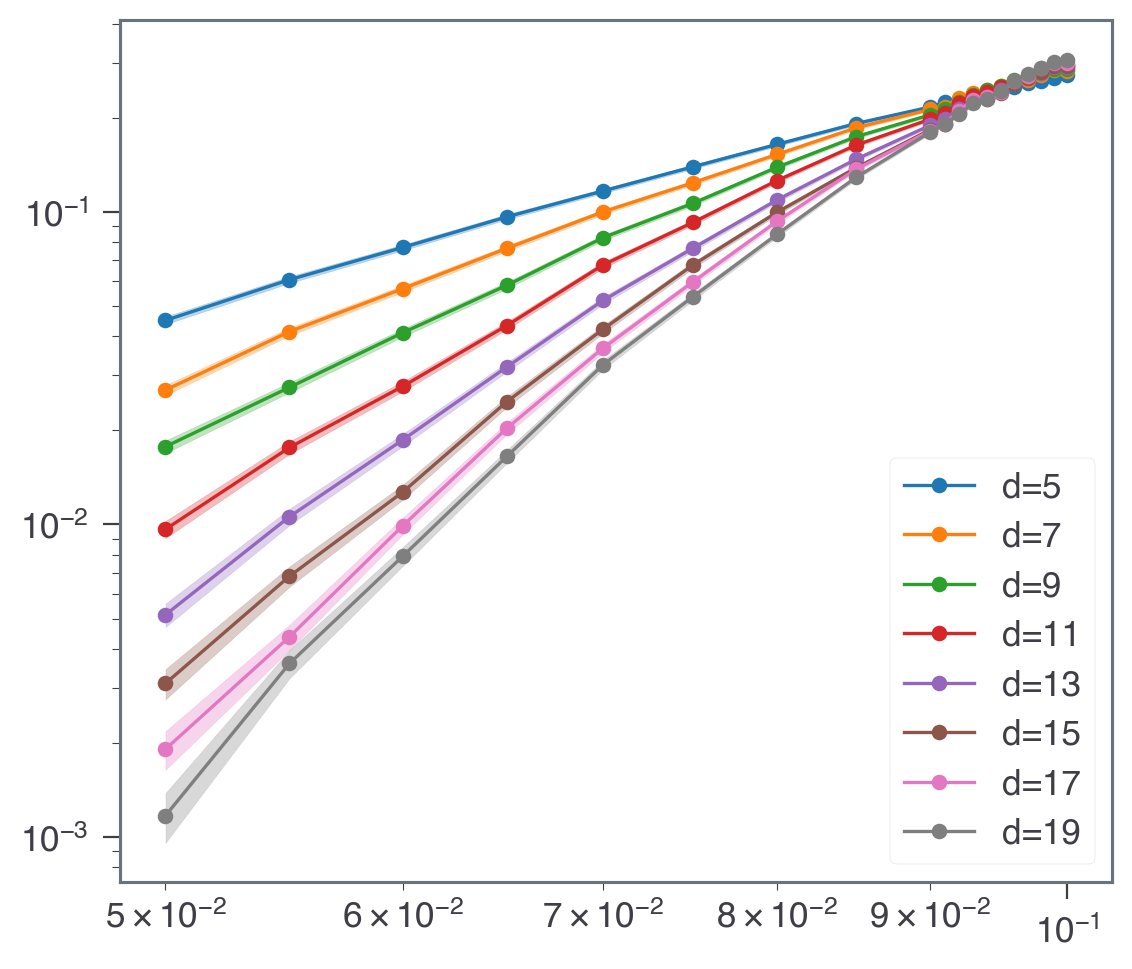

In [10]:
from simulations.analysis.plotting_helpers import error_band_plot

dlist = sorted(df_pfails.index.get_level_values("d").unique())
for i, d in enumerate(dlist):
    df_d = df_pfails.loc[d]
    error_band_plot(
        df_d.index,
        df_d["pfail"],
        df_d["delta_pfail"],
        color=COLORS(i),
        marker="o",
        label=f"d={d}",
    )

plt.xscale("log")
plt.yscale("log")
plt.legend()

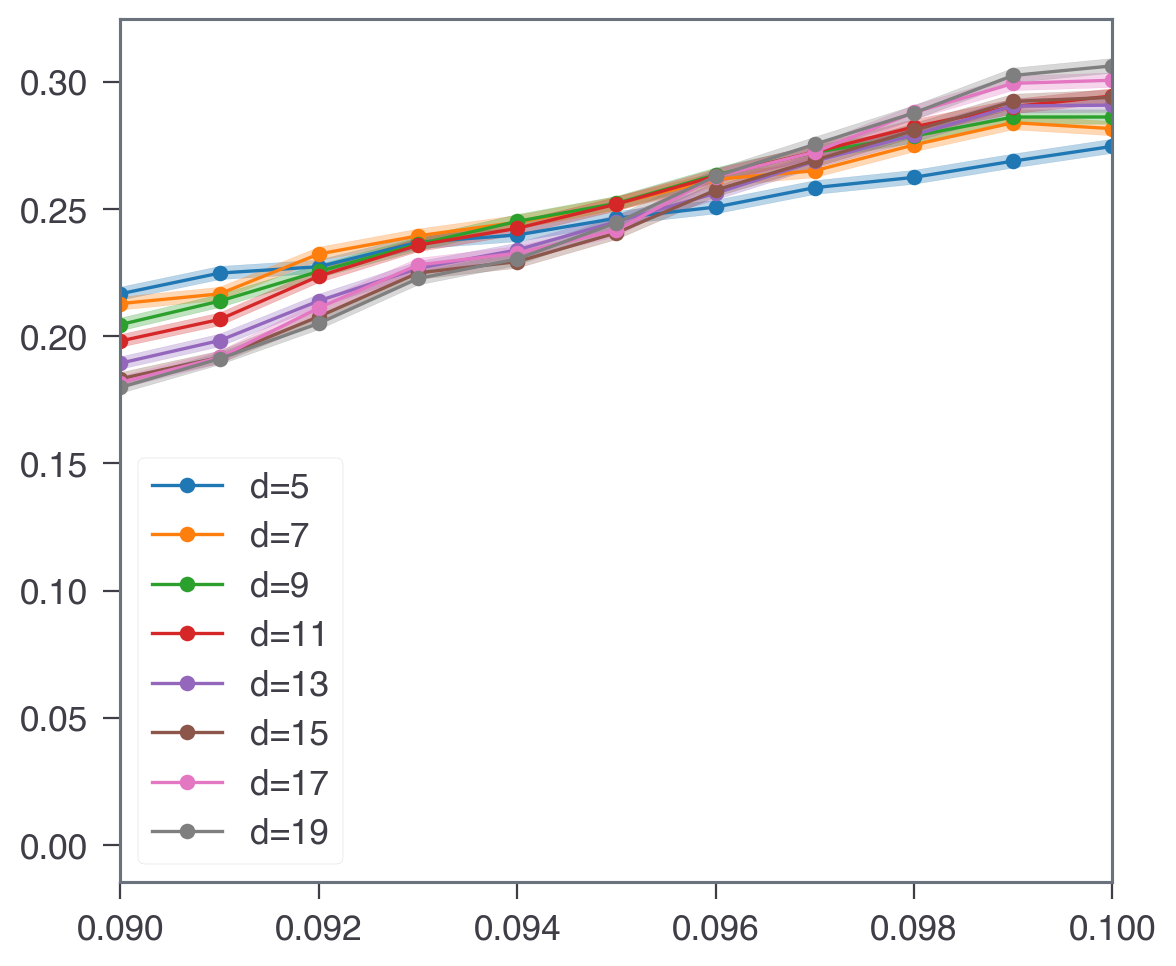

In [11]:
dlist = sorted(df_pfails.index.get_level_values("d").unique())
for i, d in enumerate(dlist):
    df_d = df_pfails.loc[d]
    error_band_plot(
        df_d.index,
        df_d["pfail"],
        df_d["delta_pfail"],
        color=COLORS(i),
        marker="o",
        label=f"d={d}",
    )

plt.xlim(0.09, 0.1)
plt.legend()

## Cluster diameter analysis

In [12]:
dlist = sorted(sample_stats.keys())
plist = sorted(sample_stats[dlist[0]].keys())

Text(0, 0.5, 'Cluster max diameter')

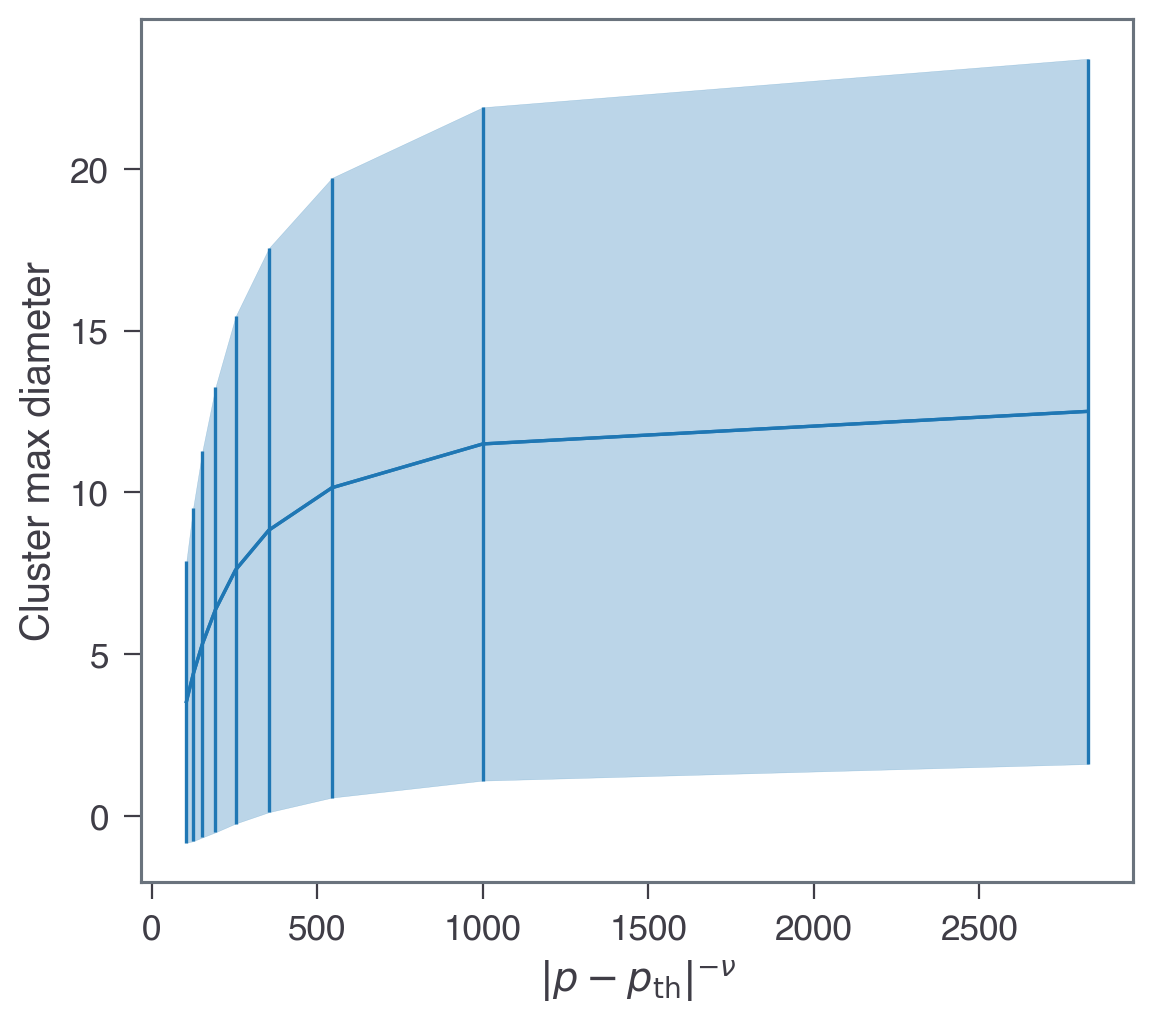

In [52]:
from simulations.analysis.plotting_helpers import error_band_plot

# Prepare data for box plot of cluster_max_diameter vs (p - pth)^{-nu}
max_diameter_mean = []
max_diameter_std = []
transformed_ps = []
pth = 0.095
nu = 1.5

for p in plist:
    if p > 0.09:
        continue
    # Collect all diameter values for this p across all d values
    all_diameters = []
    for d in dlist:
        if p in sample_stats[d]:
            diameters = sample_stats[d][p]["cluster_max_diameter"].values
            all_diameters.extend(diameters)
    all_diameters = np.array(all_diameters)
    diameter_mean = np.mean(all_diameters)
    diameter_std = np.std(all_diameters)
    transformed_p = (pth - p) ** (-nu)

    max_diameter_mean.append(diameter_mean)
    max_diameter_std.append(diameter_std)
    transformed_ps.append(transformed_p)

error_band_plot(transformed_ps, max_diameter_mean, max_diameter_std, color=COLORS(0))
plt.errorbar(transformed_ps, max_diameter_mean, yerr=max_diameter_std, color=COLORS(0))
plt.xlabel(r"$|p - p_\mathrm{th}|^{-\nu}$")
plt.ylabel("Cluster max diameter")

# Without cluster diameters

In [2]:
from simulations.toric_code_bitflip_simulation import (
    get_existing_simulation_params,
)

params = get_existing_simulation_params()
dlist = np.unique([p[0] for p in params])
plist = np.unique([p[1] for p in params])

In [3]:
dlist

array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 25, 29, 33, 37])

In [4]:
plist

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.091,
       0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1  ,
       0.105, 0.11 ])

In [5]:
import os
import pickle

stats_dir = "../../data/toric_minsum_iter30_lsd0_bitflip_raw/stats"

# Load all statistics files into nested dictionary structure
sample_stats = {}
density_stats = {}

plist = np.arange(0.01, 0.1101, 0.005).round(3)
dlist = np.arange(5, 38, 4)
# Get all pickle files in stats directory
for filename in os.listdir(stats_dir):
    if filename.endswith(".pkl"):
        # Parse filename to extract d and p values
        # Format: d{d}_p{p:.3f}.pkl
        parts = filename[:-4].split("_")  # Remove .pkl extension
        d = int(parts[0][1:])  # Remove 'd' prefix
        p = float(parts[1][1:])  # Remove 'p' prefix

        if d not in dlist or p not in plist:
            continue

        # Load the dataframe
        filepath = os.path.join(stats_dir, filename)
        df = read_pickle(filepath)

        if "corr_length" not in df.columns:
            continue

        if "samples" in filename:
            if d not in sample_stats:
                sample_stats[d] = {}

            sample_stats[d][p] = df
        elif "density" in filename:
            if d not in density_stats:
                density_stats[d] = {}

            density_stats[d][p] = df

## Logical error rate plot

In [37]:
from statsmodels.stats.proportion import proportion_confint

# Calculate failure rates for each (d, p) combination
failure_rates = []

for d in sample_stats:
    for p in sample_stats[d]:
        df = sample_stats[d][p]
        total_samples = len(df)
        failed_samples = df["fail"].sum()
        lower, upper = proportion_confint(failed_samples, total_samples, alpha=0.05)
        pfails = (lower + upper) / 2
        delta_pfails = upper - pfails

        failure_rates.append(
            {"d": d, "p": p, "pfail": pfails, "delta_pfail": delta_pfails}
        )

# Create dataframe with failure rates
df_pfails = pd.DataFrame(failure_rates).set_index(["d", "p"]).sort_index()
df_pfails.head()

pfail  delta_pfail
d p                           
5 0.010  0.000267     0.000032
  0.015  0.000979     0.000061
  0.020  0.002497     0.000098
  0.025  0.005259     0.000142
  0.030  0.009244     0.000188

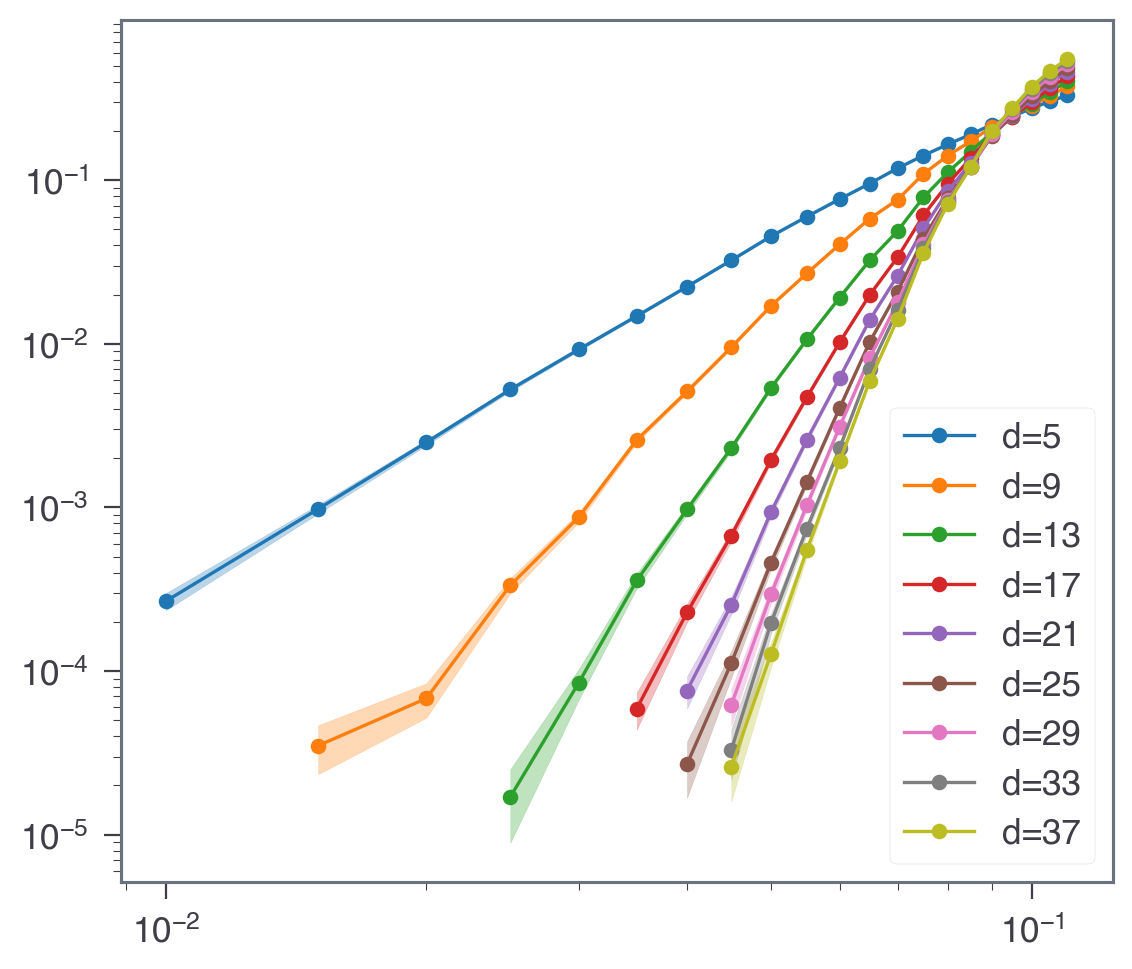

In [38]:
from simulations.analysis.plotting_helpers import error_band_plot

dlist = sorted(df_pfails.index.get_level_values("d").unique())
for i, d in enumerate(dlist):
    df_d = df_pfails.loc[d]
    mask = df_d["delta_pfail"] / df_d["pfail"] < 0.5
    df_d = df_d[mask]
    error_band_plot(
        df_d.index,
        df_d["pfail"],
        df_d["delta_pfail"],
        color=COLORS(i),
        marker="o",
        label=f"d={d}",
    )

plt.xscale("log")
plt.yscale("log")
plt.legend()

## Cluster number density analysis

Text(0.5, 1.0, 'Cluster number density for d=13')

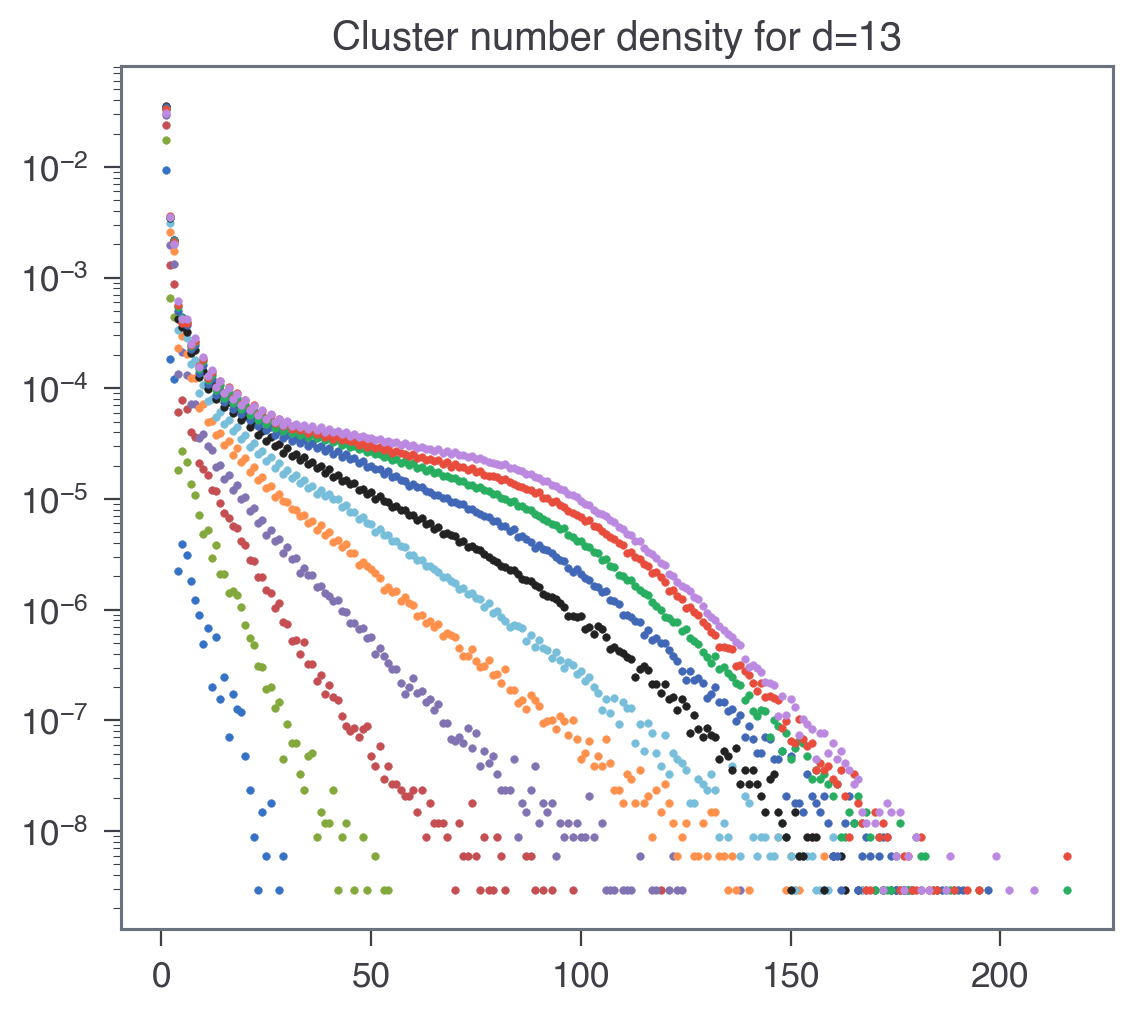

In [70]:
from scipy.optimize import curve_fit

d = 13

density_stats_d = density_stats[d]
plist = np.arange(0.01, 0.1101, 0.01).round(3)

fit_results = []

for p in plist:
    df_density = density_stats_d[p]

    plt.scatter(
        df_density["cluster_sizes"],
        df_density["cluster_number_density"],
        marker=".",
        label=f"p={p}",
    )

plt.yscale("log")
# plt.xscale('log')
plt.title(f"Cluster number density for d={d}")

In [61]:
def ansatz(s, s_xi, tau):
    return -tau * np.log(s) - s / s_xi

p=0.01: s_xi=64942376.704±226399605064812.844, tau=5.955±0.564
p=0.02: s_xi=79640532.955±88192293325568.609, tau=4.937±0.208
p=0.03: s_xi=79774617.109±20993869096566.922, tau=4.321±0.082
p=0.04: s_xi=89.595±30.493, tau=3.730±0.067
p=0.05: s_xi=62.200±10.711, tau=3.292±0.057
p=0.06: s_xi=42.667±4.695, tau=2.931±0.058
p=0.07: s_xi=39.745±4.605, tau=2.704±0.066
p=0.08: s_xi=32.914±2.932, tau=2.462±0.067
p=0.09: s_xi=33.068±3.156, tau=2.358±0.072
p=0.1: s_xi=33.670±3.574, tau=2.298±0.079
p=0.11: s_xi=36.087±4.235, tau=2.280±0.081


Text(0.5, 1.0, 'Cluster number density for d=13')

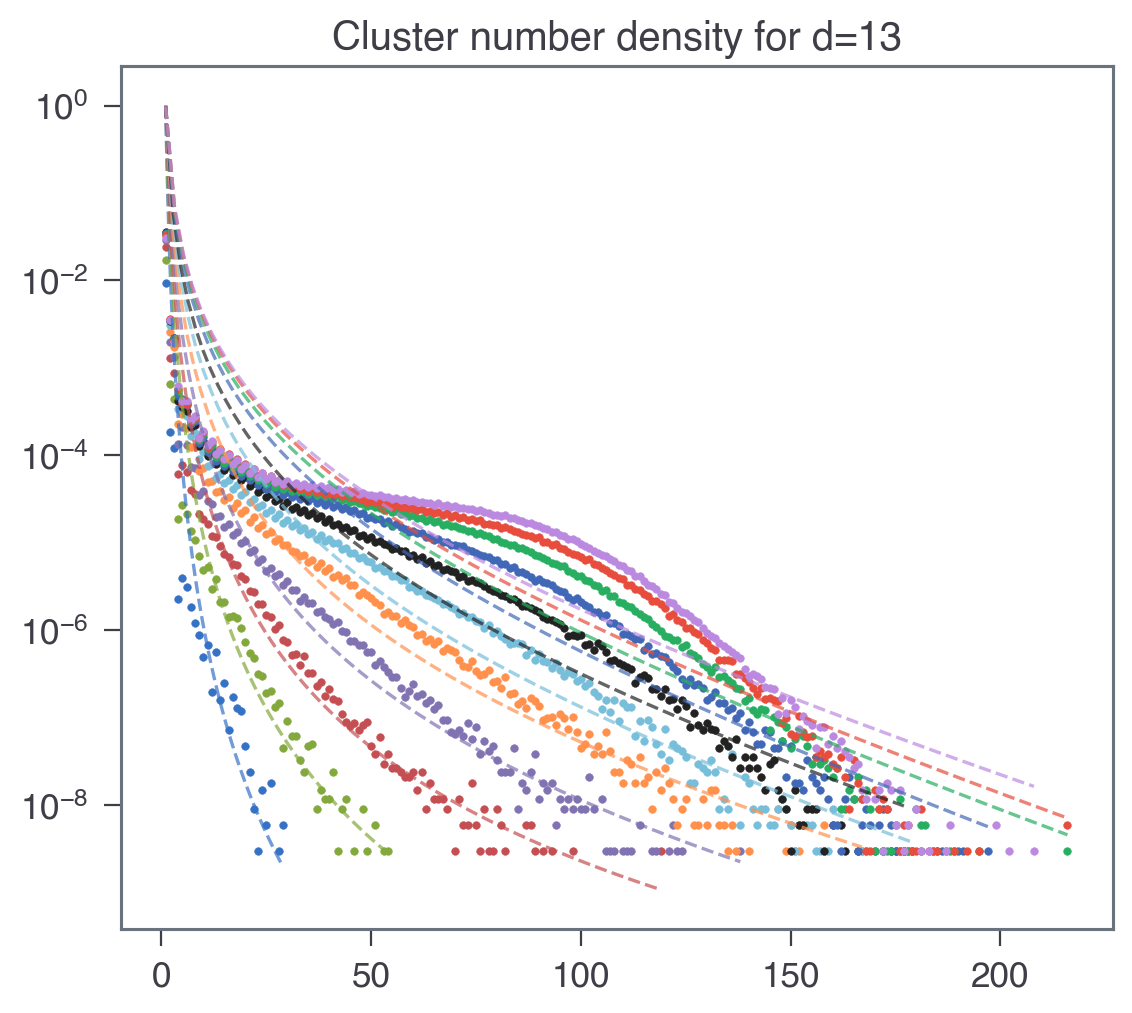

In [66]:
from scipy.optimize import curve_fit

d = 13

density_stats_d = density_stats[d]
plist = np.arange(0.01, 0.1101, 0.01).round(3)

fit_results = []

for p in plist:
    df_density = density_stats_d[p]

    plt.scatter(
        df_density["cluster_sizes"],
        df_density["cluster_number_density"],
        marker=".",
        label=f"p={p}",
    )

    # Perform curve fitting
    try:
        s = df_density["cluster_sizes"].values
        n_s = df_density["cluster_number_density"].values

        # Fit to log(n(s)) = ansatz(s, s_xi, tau)
        popt, pcov = curve_fit(ansatz, s, np.log(n_s))
        s_xi_fit, tau_fit = popt

        # Generate fitted curve
        s_range = np.linspace(s.min(), s.max(), 100)
        n_s_fitted = np.exp(ansatz(s_range, s_xi_fit, tau_fit))

        # Plot fitted curve
        plt.plot(
            s_range,
            n_s_fitted,
            "--",
            alpha=0.7,
            label=f"p={p} fit: s_xi={s_xi_fit:.2f}, tau={tau_fit:.2f}",
        )

        fit_results.append(
            {
                "p": p,
                "s_xi": s_xi_fit,
                "tau": tau_fit,
                "fit_error": np.sqrt(np.diag(pcov)),
            }
        )

        print(
            f"p={p}: s_xi={s_xi_fit:.3f}±{np.sqrt(pcov[0,0]):.3f}, tau={tau_fit:.3f}±{np.sqrt(pcov[1,1]):.3f}"
        )

    except Exception as e:
        print(f"Fitting failed for p={p}: {e}")

plt.yscale("log")
plt.title(f"Cluster number density for d={d}")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

Text(0.5, 1.0, 'Cluster number density for p=0.05')

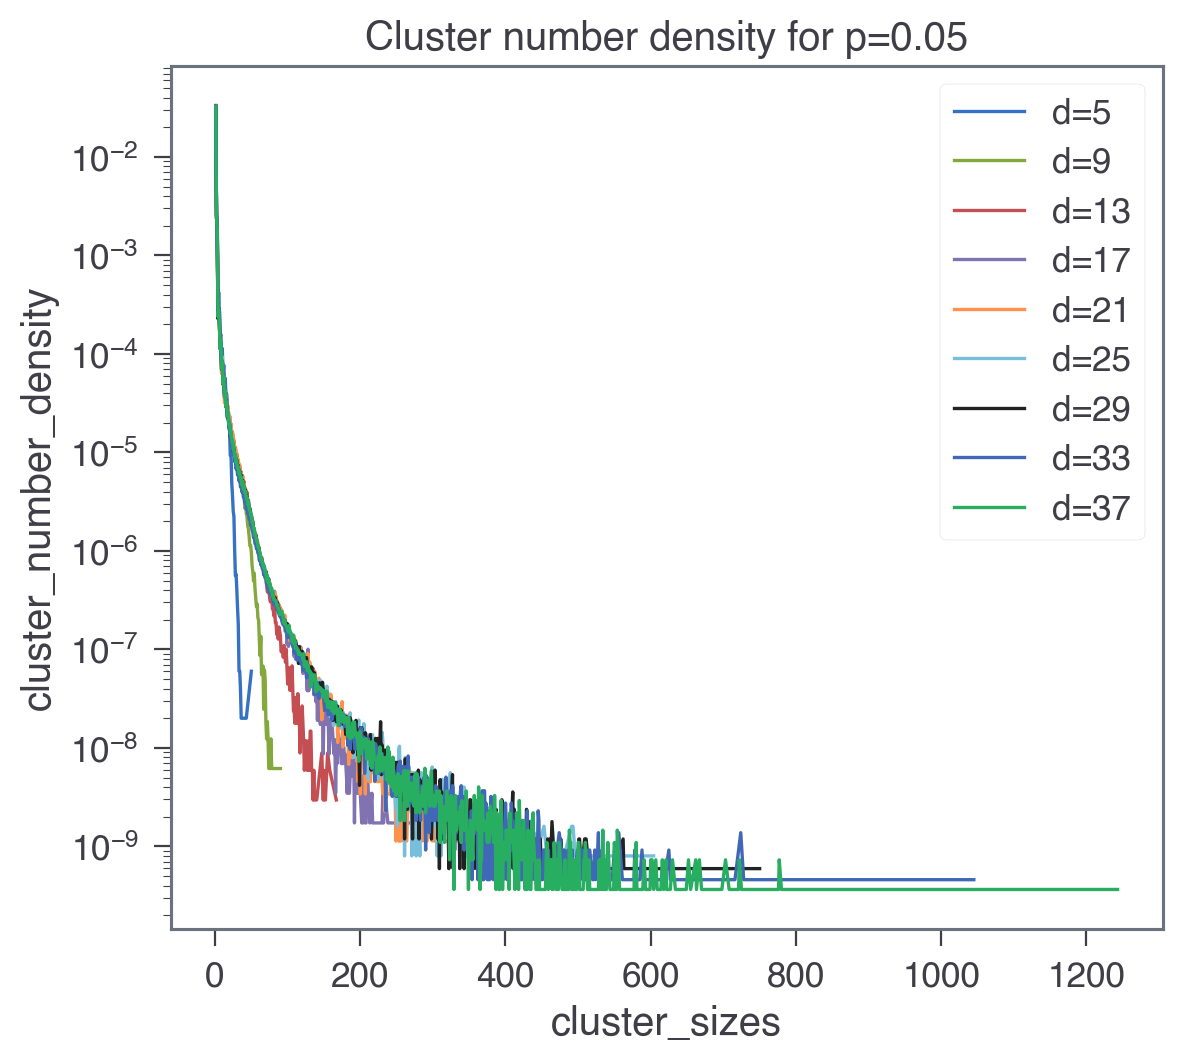

In [54]:
p = 0.05

dlist = np.arange(5, 38, 4)
for d in dlist:
    df_density = density_stats[d][p]
    sns.lineplot(
        df_density,
        x="cluster_sizes",
        y="cluster_number_density",
        label=f"d={d}",
    )
plt.yscale("log")
plt.title(f"Cluster number density for p={p}")

## Percolation analysis

In [6]:
sample_stats[5][0.05].head()

fail  moment_1  moment_2  max_cluster_size  corr_length  \
0  False      0.06      0.06                 1          0.0   
1  False      0.04      0.04                 1          0.0   
2  False      0.02      0.02                 1          0.0   
3  False      0.08      0.08                 1          0.0   
4  False      0.02      0.02                 1          0.0   

   corr_length_manhattan  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

In [7]:
# Cluster statistics

cluster_size_data = []


for d in sample_stats:
    for p in sample_stats[d]:
        df = sample_stats[d][p]
        fails = df["fail"]
        # percs = df["perc"]
        moment1 = df["moment_1"]
        moment2 = df["moment_2"]
        sample_corr_lengths = df["corr_length"]
        moment1_s = moment1[~fails]
        moment2_s = moment2[~fails]
        sample_corr_lengths_s = sample_corr_lengths[~fails]
        moment1_f = moment1[fails]
        moment2_f = moment2[fails]
        sample_corr_lengths_f = sample_corr_lengths[fails]

        p_fail = fails.mean()
        # p_perc, p_perc_f, p_perc_s = get_means(percs)
        avg_moment1 = moment1.mean()
        avg_moment2 = moment2.mean()
        avg_moment1_s = moment1_s.mean()
        avg_moment2_s = moment2_s.mean()
        avg_moment1_f = moment1_f.mean()
        avg_moment2_f = moment2_f.mean()

        avg_cluster_size = avg_moment2 / avg_moment1
        avg_cluster_size_f = avg_moment2_f / avg_moment1_f
        avg_cluster_size_s = avg_moment2_s / avg_moment1_s

        weighted_mean = lambda x, w: np.sum(x * w) / np.sum(w)

        corr_length = np.sqrt(weighted_mean(sample_corr_lengths**2, moment2))
        corr_length_s = np.sqrt(weighted_mean(sample_corr_lengths_s**2, moment2_s))
        corr_length_f = np.sqrt(weighted_mean(sample_corr_lengths_f**2, moment2_f))

        cluster_size_data.append(
            {
                "d": d,
                "p": p,
                "p_fail": p_fail,
                # "p_perc": p_perc,
                # "p_perc_f": p_perc_f,
                # "p_perc_s": p_perc_s,
                "avg_moment1": avg_moment1,
                "avg_moment1_f": avg_moment1_f,
                "avg_moment1_s": avg_moment1_s,
                "avg_moment2": avg_moment2,
                "avg_moment2_f": avg_moment2_f,
                "avg_moment2_s": avg_moment2_s,
                "avg_cluster_size": avg_cluster_size,
                "avg_cluster_size_f": avg_cluster_size_f,
                "avg_cluster_size_s": avg_cluster_size_s,
                "corr_length": corr_length,
                "corr_length_f": corr_length_f,
                "corr_length_s": corr_length_s,
            }
        )

# Create dataframe with mean average cluster sizes
df_cluster_stats = pd.DataFrame(cluster_size_data).set_index(["d", "p"]).sort_index()
df_cluster_stats.head()

/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_37023/209654358.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_mean = lambda x, w: np.sum(x * w) / np.sum(w)


p_fail  avg_moment1  avg_moment1_f  avg_moment1_s  avg_moment2  \
d p                                                                         
5 0.010  0.000267     0.010242       0.130262       0.010210     0.012574   
  0.015  0.000979     0.015535       0.128355       0.015425     0.021471   
  0.020  0.002497     0.021102       0.138478       0.020808     0.034639   
  0.025  0.005259     0.026880       0.143693       0.026263     0.051859   
  0.030  0.009244     0.033009       0.154083       0.031879     0.074922   

         avg_moment2_f  avg_moment2_s  avg_cluster_size  avg_cluster_size_f  \
d p                                                                           
5 0.010       1.038876       0.012300          1.227685            7.975273   
  0.015       1.027028       0.020486          1.382108            8.001432   
  0.020       1.148010       0.031852          1.641486            8.290185   
  0.025       1.216558       0.045701          1.929249            8.466388   
  0.030       1.380772       0.062738          2.269722            8.961245   

         avg_cluster_size_s  corr_length  corr_length_f  corr_length_s  
d p                                                                     
5 0.010            1.204694     0.735265       2.032504       0.677955  
  0.015            1.328130     0.937714       2.041531       0.847199  
  0.020            1.530725     1.172851       2.069641       1.055095  
  0.025            1.740155     1.344096       2.083455       1.204137  
  0.030            1.967963     1.486155       2.101220       1.324978

### Correlation length

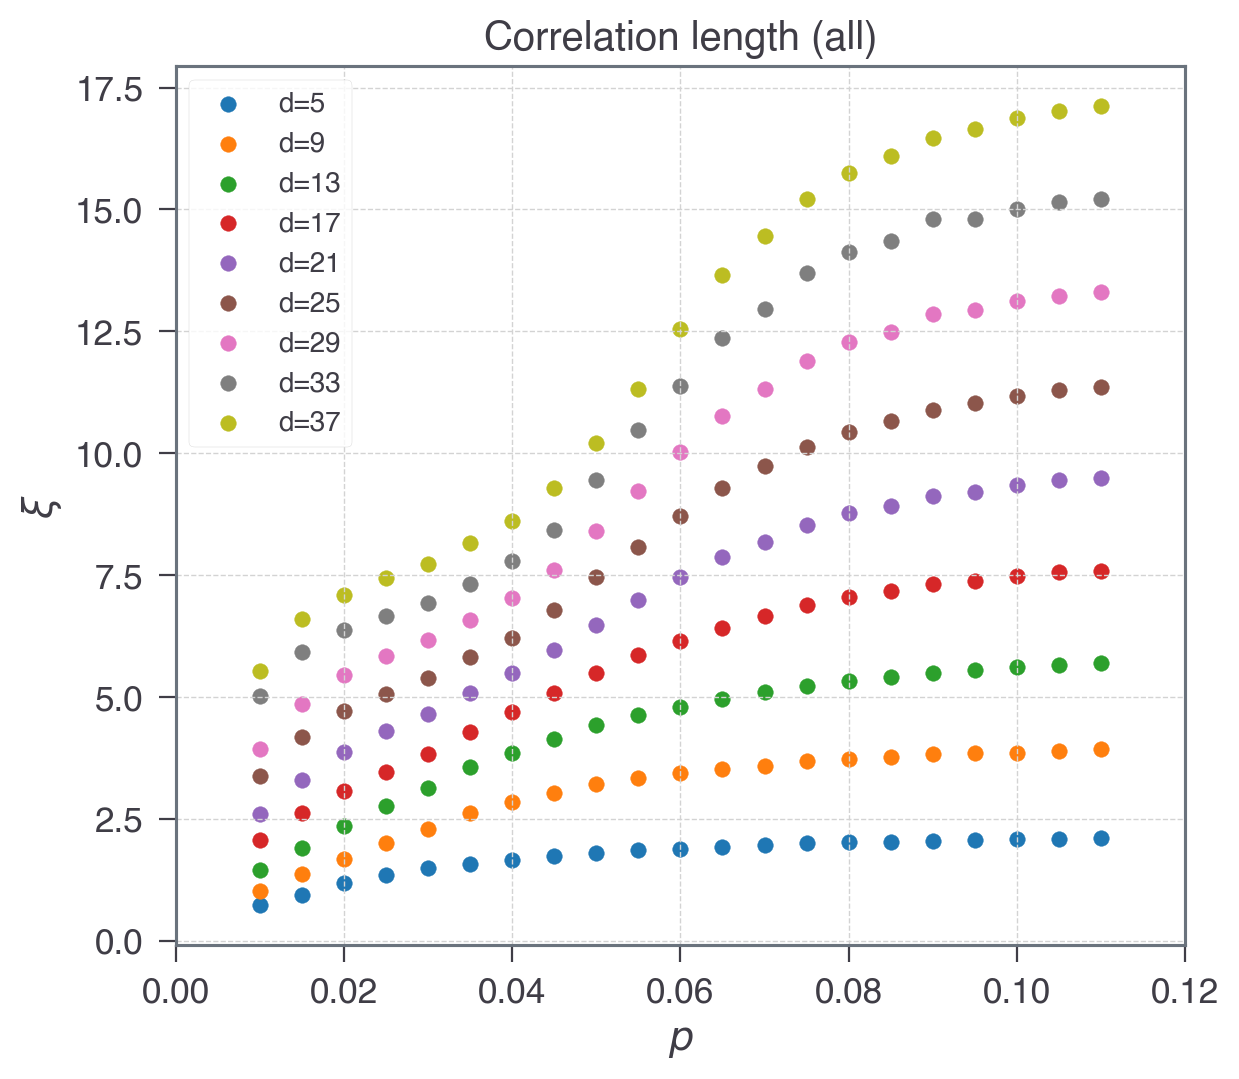

In [8]:
for i_d, d in enumerate(dlist):
    try:
        df_d = df_cluster_stats.loc[d].reset_index()
        color = COLORS(i_d)

        # Plot scatter points
        plt.scatter(df_d["p"], df_d["corr_length"], color=color, label=f"d={d}")

    except:
        continue

plt.title("Correlation length (all)")
plt.xlim(0, 0.12)
plt.xlabel(r"$p$")
plt.ylabel(r"$\xi$")
plt.legend(fontsize=10)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()

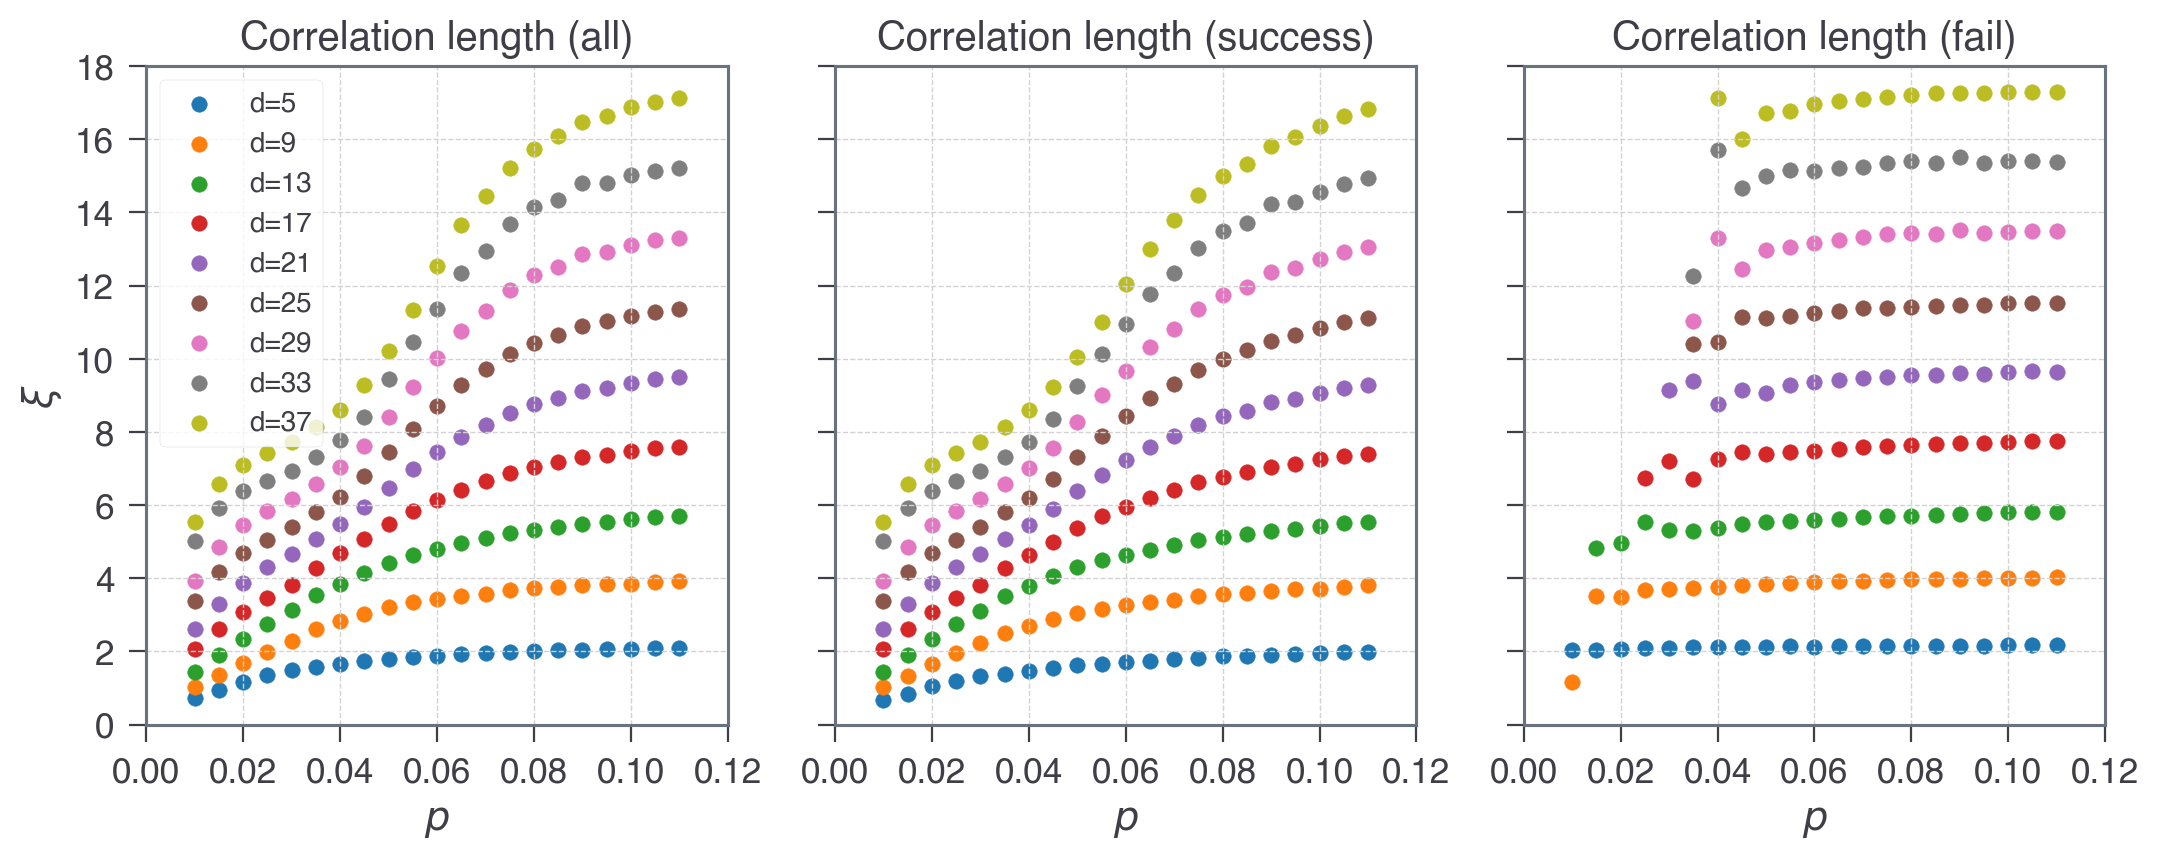

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4.5), sharey=True)

# Correlation length columns to plot
corr_columns = ["corr_length", "corr_length_s", "corr_length_f"]
titles = [
    "Correlation length (all)",
    "Correlation length (success)",
    "Correlation length (fail)",
]

for col_idx, (col, title) in enumerate(zip(corr_columns, titles)):
    ax = axes[col_idx]

    for i_d, d in enumerate(dlist):
        try:
            df_d = df_cluster_stats.loc[d].reset_index()
            color = COLORS(i_d)

            # Plot scatter points
            ax.scatter(df_d["p"], df_d[col], color=color, label=f"d={d}")

        except:
            continue

    ax.set_title(title)
    ax.set_xlim(0, 0.12)
    ax.set_xticks(np.linspace(0, 0.12, 7))
    ax.set_xlabel(r"$p$")
    ax.set_ylim(0, 18)
    if col_idx == 0:
        ax.set_ylabel(r"$\xi$")
        ax.legend(fontsize=10)
    ax.grid(color="lightgray", linestyle="--", linewidth=0.5)

fig.tight_layout()

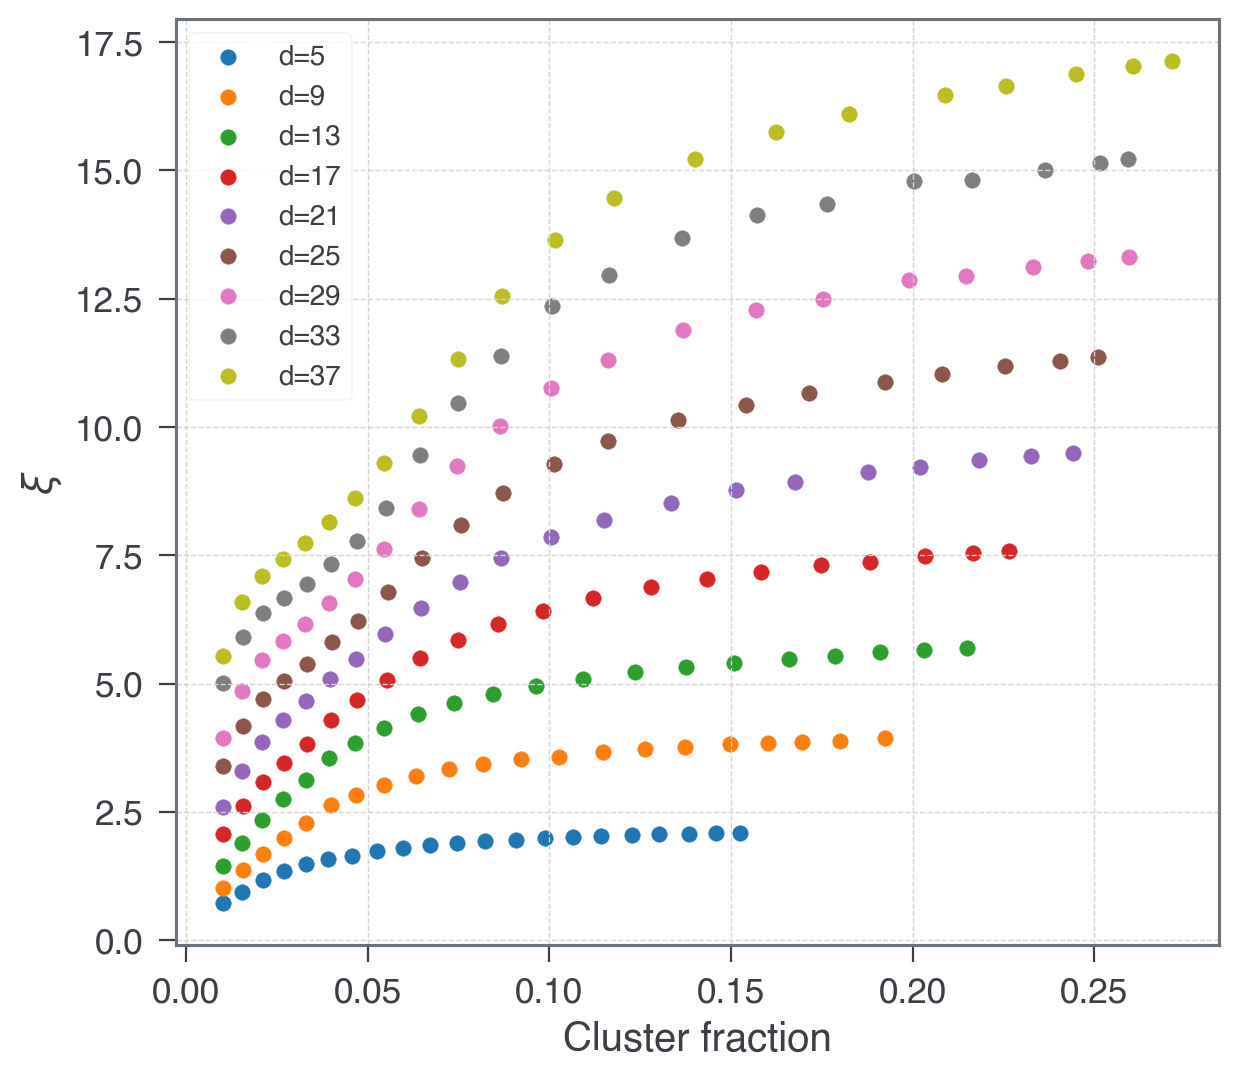

In [9]:
for i_d, d in enumerate(dlist):
    try:
        df_d = df_cluster_stats.loc[d].reset_index()
        color = COLORS(i_d)

        # Plot scatter points
        plt.scatter(
            df_d["avg_moment1"], df_d["corr_length"], color=color, label=f"d={d}"
        )

    except:
        continue

# plt.xlim(0, 0.12)
plt.xlabel(r"Cluster fraction")
plt.ylabel(r"$\xi$")
plt.legend(fontsize=10)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()

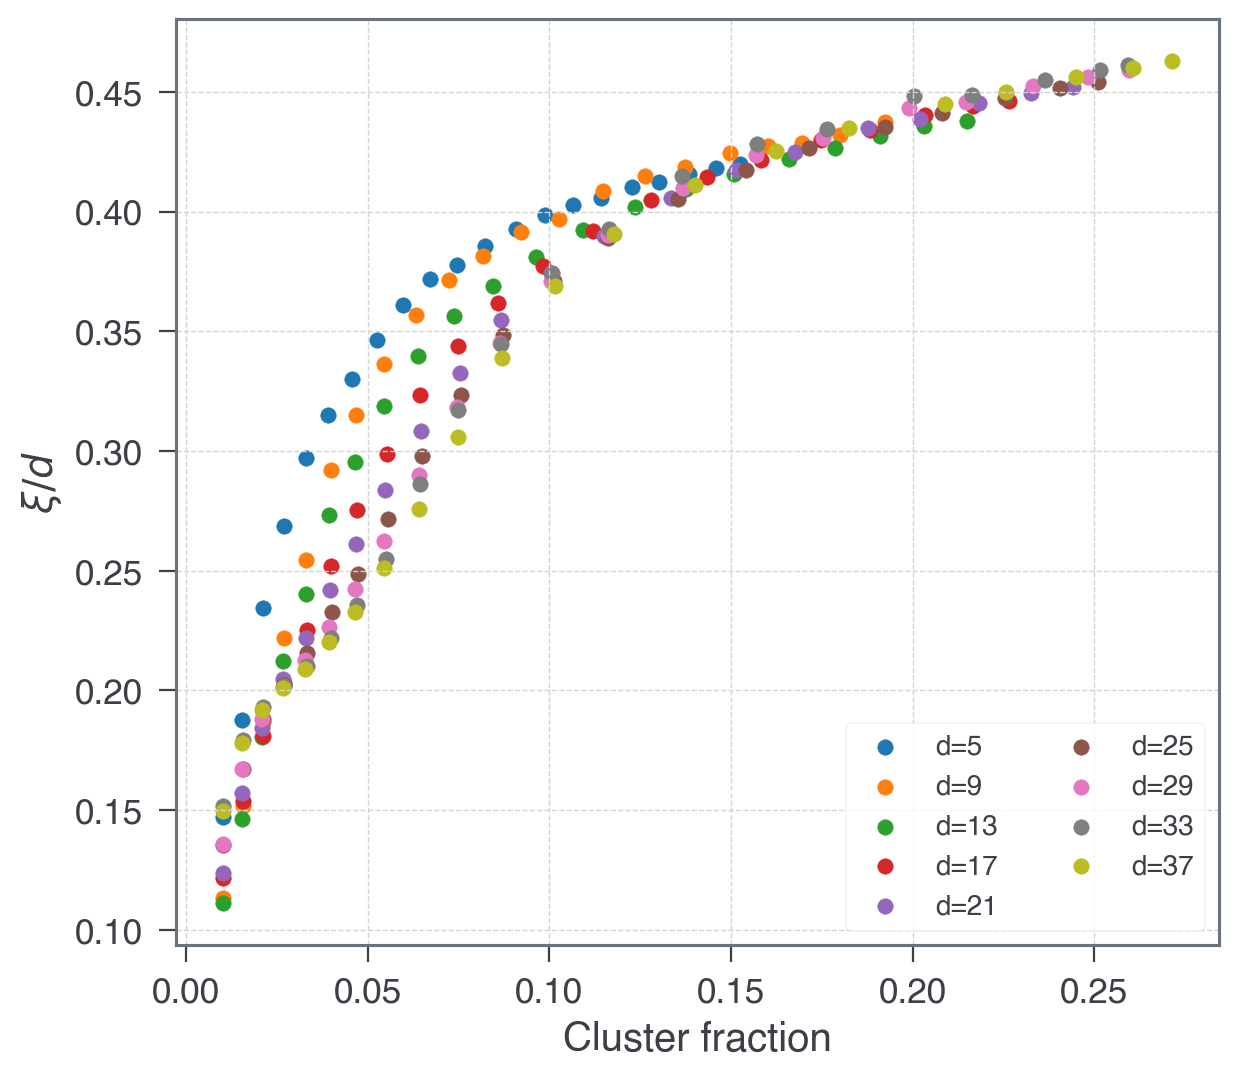

In [10]:
for i_d, d in enumerate(dlist):
    try:
        df_d = df_cluster_stats.loc[d].reset_index()
        color = COLORS(i_d)

        # Plot scatter points
        plt.scatter(
            df_d["avg_moment1"],
            df_d["corr_length"] / d,
            color=color,
            label=f"d={d}",
        )

    except:
        continue

plt.xlabel(r"Cluster fraction")
plt.ylabel(r"$\xi / d$")
plt.legend(fontsize=10, ncol=2)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()

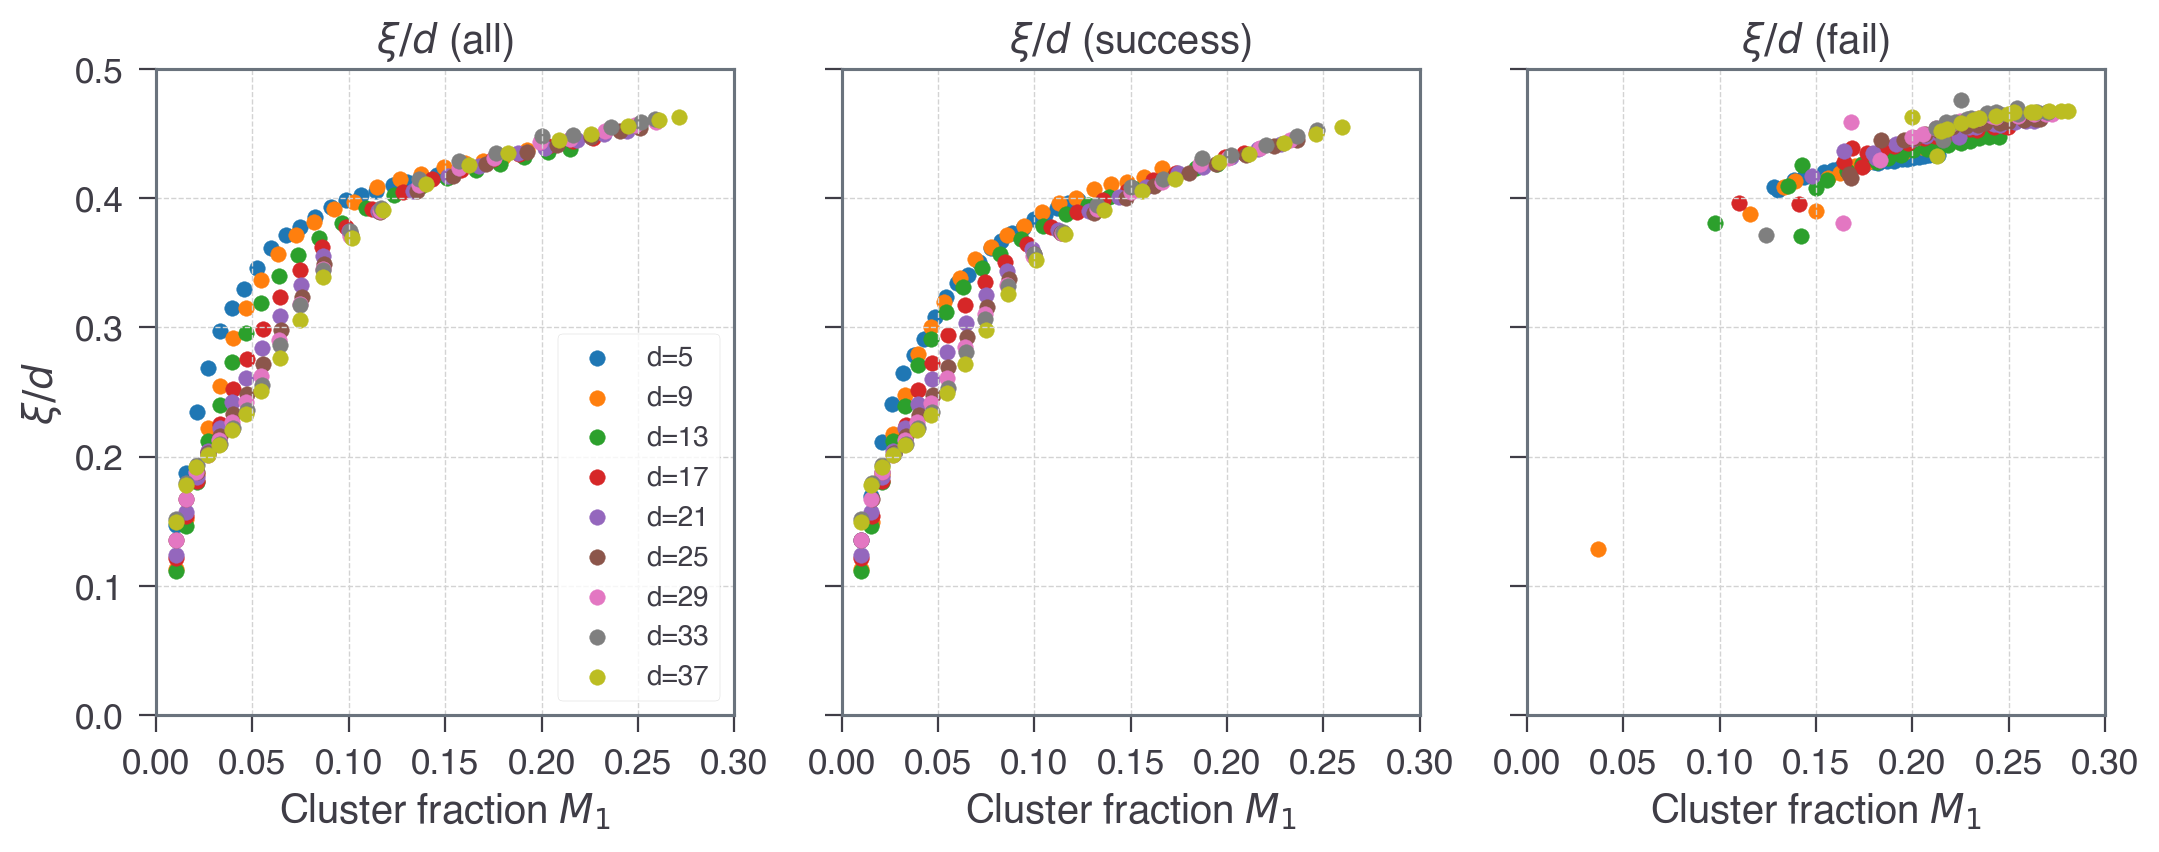

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4.5), sharey=True)

# Correlation length columns to plot
corr_columns = ["corr_length", "corr_length_s", "corr_length_f"]
moment1_columns = ["avg_moment1", "avg_moment1_s", "avg_moment1_f"]
titles = [
    r"$\xi / d$ (all)",
    r"$\xi / d$ (success)",
    r"$\xi / d$ (fail)",
]

for col_idx, (col, moment1_col, title) in enumerate(
    zip(corr_columns, moment1_columns, titles)
):
    ax = axes[col_idx]

    for i_d, d in enumerate(dlist):
        try:
            df_d = df_cluster_stats.loc[d].reset_index()
            color = COLORS(i_d)

            # Plot scatter points
            ax.scatter(df_d[moment1_col], df_d[col] / d, color=color, label=f"d={d}")

        except:
            continue

    ax.set_title(title)
    ax.set_xlim(0, 0.12)
    ax.set_xticks(np.linspace(0, 0.3, 7))
    ax.set_xlabel(r"Cluster fraction $M_1$")
    ax.set_ylim(0, 0.5)
    if col_idx == 0:
        ax.set_ylabel(r"$\xi / d$")
        ax.legend(fontsize=10)
    ax.grid(color="lightgray", linestyle="--", linewidth=0.5)

fig.tight_layout()

In [169]:
from simulations.analysis.percolation_utils import find_optimal_collapse_ssr

cluster_fraction_all = df_cluster_stats["avg_moment1"].values
d_all = df_cluster_stats.index.get_level_values("d").values
corr_length_all = df_cluster_stats["corr_length"].values

initial_guess = [0.5, 1.3]
bounds = [(0, 0), (1, np.inf)]

eta_c, nu, min_ssr, result = find_optimal_collapse_ssr(
    cluster_fraction_all,
    d_all,
    corr_length_all,
    initial_guess,
    bounds=bounds,
)
print(f"eta_c = {eta_c:.4f}, nu = {nu:.4f}")
print(f"min_ssr = {min_ssr:.4f}")

eta_c = 0.0000, nu = 1.0000
min_ssr = 420.6826


<string>:35: OptimizeWarning: Initial guess is not within the specified bounds


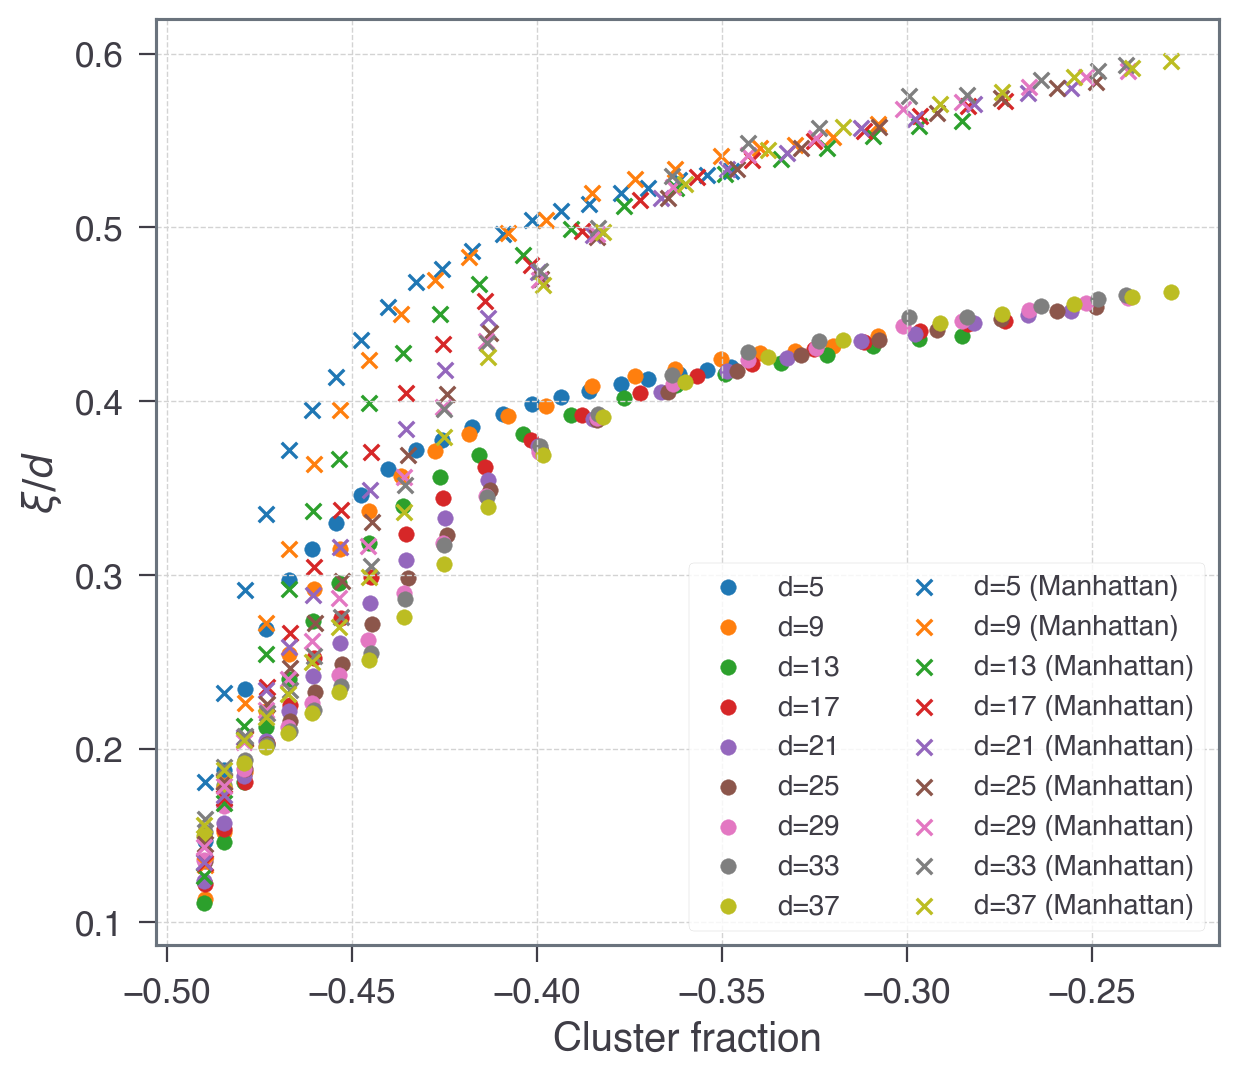

In [178]:
draw_euclidean = True
draw_manhattan = True

scale_x = lambda eta, d: (eta - eta_c) * (d ** (1 / nu))

if draw_euclidean:
    for i_d, d in enumerate(dlist):
        try:
            df_d = df_cluster_stats.loc[d].reset_index()
            color = COLORS(i_d)

            # Plot scatter points
            plt.scatter(
                scale_x(df_d["avg_moment1"], d),
                df_d["corr_length"] / d,
                color=color,
                label=f"d={d}",
            )

        except:
            continue

if draw_manhattan:
    for i_d, d in enumerate(dlist):
        try:
            df_d = df_cluster_stats.loc[d].reset_index()
            color = COLORS(i_d)

            if draw_manhattan:
                plt.scatter(
                    scale_x(df_d["avg_moment1"], d),
                    df_d["corr_length_manhattan"] / d,
                    marker="x",
                    color=color,
                    label=f"d={d} (Manhattan)",
                )

        except:
            continue

plt.xlabel(r"Cluster fraction")
plt.ylabel(r"$\xi / d$")
plt.legend(fontsize=10, ncol=2)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()

In [128]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def ansatz1(prms, p_c, r, a, nu):
    d, p = prms
    x = (p - p_c) * d ** (1 / nu)
    return d * r / (1 + a * np.abs(x) ** nu)

def ansatz2(prms, p_c, )

In [116]:
# p vs corr length


d_all = df_cluster_stats.index.get_level_values("d")
p_all = df_cluster_stats.index.get_level_values("p")
corr_lengths = df_cluster_stats["corr_length"]
corr_lengths_manhattan = df_cluster_stats["corr_length_manhattan"]

# Prepare data for fitting
prms_data = np.column_stack([d_all, p_all])

init_guess = [0.2, 0.5, 1.0, 1.3]

# Fit correlation length (Euclidean)
try:
    popt_corr, pcov_corr = curve_fit(
        ansatz1,
        prms_data.T,
        corr_lengths.values,
        p0=init_guess,
    )
    p_c_corr, r_corr, a_corr, nu_corr = popt_corr

    # Calculate R-squared
    y_pred_corr = ansatz1(prms_data.T, *popt_corr)
    r2_corr = r2_score(corr_lengths.values, y_pred_corr)

    print(f"Correlation length (Euclidean) fit:")
    print(f"  p_c = {p_c_corr:.4f}")
    print(f"  r = {r_corr:.4f}")
    print(f"  a = {a_corr:.4f}")
    print(f"  nu = {nu_corr:.4f}")
    print(f"  R² = {r2_corr:.4f}")
except Exception as e:
    print(f"Fitting failed for correlation length (Euclidean): {e}")
    popt_corr = None

# Fit correlation length (Manhattan)
try:
    popt_corr_manhattan, pcov_corr_manhattan = curve_fit(
        ansatz1,
        prms_data.T,
        corr_lengths_manhattan.values,
        p0=init_guess,
    )
    p_c_corr_manhattan, r_corr_manhattan, a_corr_manhattan, nu_corr_manhattan = (
        popt_corr_manhattan
    )

    # Calculate R-squared
    y_pred_corr_manhattan = ansatz1(prms_data.T, *popt_corr_manhattan)
    r2_corr_manhattan = r2_score(corr_lengths_manhattan.values, y_pred_corr_manhattan)

    print(f"\nCorrelation length (Manhattan) fit:")
    print(f"  p_c = {p_c_corr_manhattan:.4f}")
    print(f"  r = {r_corr_manhattan:.4f}")
    print(f"  a = {a_corr_manhattan:.4f}")
    print(f"  nu = {nu_corr_manhattan:.4f}")
    print(f"  R² = {r2_corr_manhattan:.4f}")
except Exception as e:
    print(f"Fitting failed for correlation length (Manhattan): {e}")
    popt_corr_manhattan = None

Correlation length (Euclidean) fit:
  p_c = 0.1026
  r = 0.4390
  a = 24.6139
  nu = 2.4541
  R² = 0.9761

Correlation length (Manhattan) fit:
  p_c = 0.1039
  r = 0.5635
  a = 69.5195
  nu = 2.7813
  R² = 0.9829


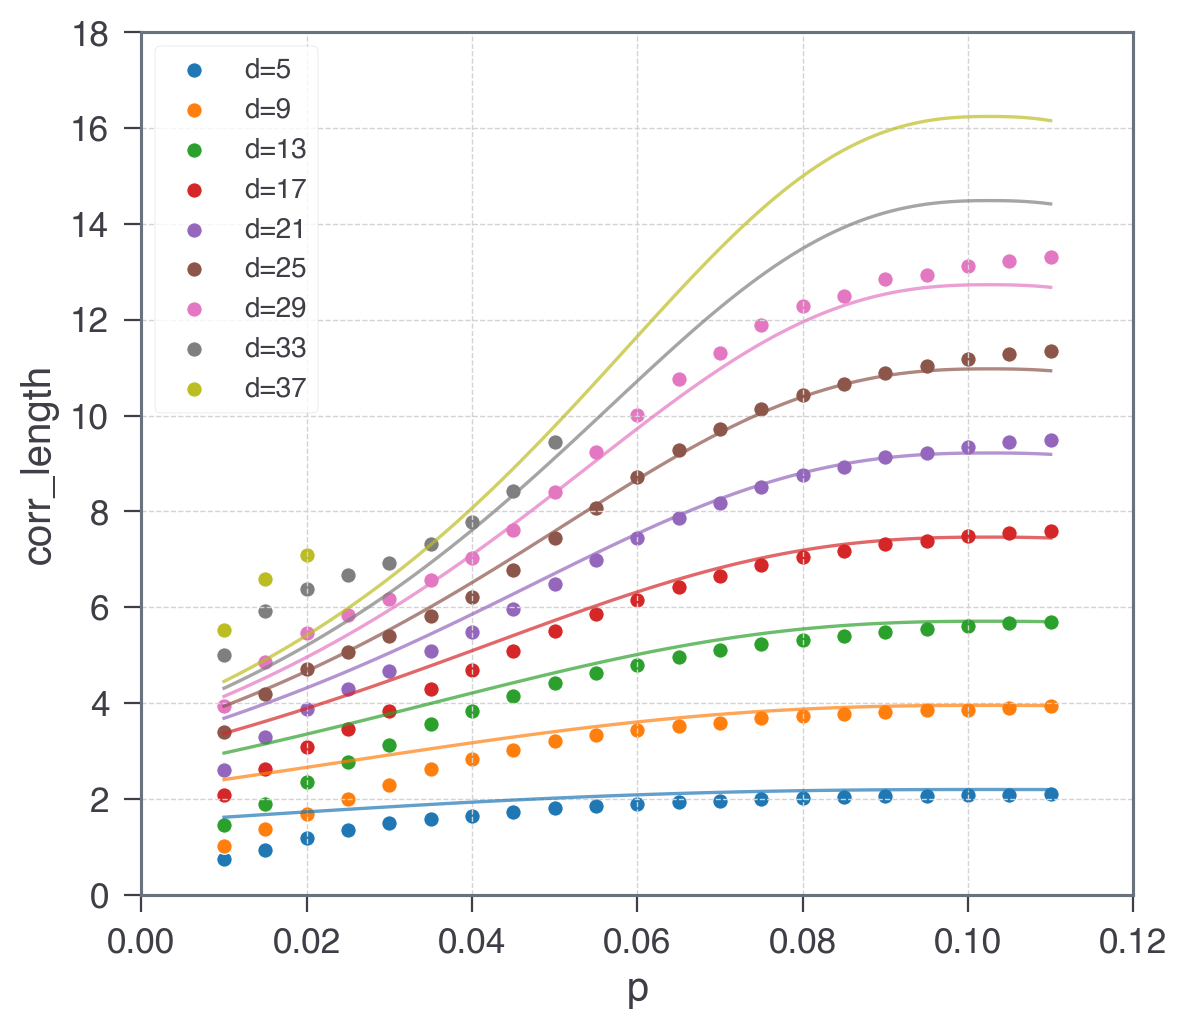

In [117]:
# Create p values for smooth fitted curves
p_smooth = np.linspace(0.01, 0.11, 100)

draw_euclidean = True
draw_manhattan = False

for i_d, d in enumerate(dlist):
    try:
        df_d = df_cluster_stats.loc[d].reset_index()
        color = COLORS(i_d)

        # Plot scatter points
        if draw_euclidean:
            sns.scatterplot(df_d, x="p", y="corr_length", color=color, label=f"d={d}")
        if draw_manhattan:
            sns.scatterplot(
                df_d,
                x="p",
                y="corr_length_manhattan",
                marker="x",
                color=color,
                label=f"d={d} (Manhattan)",
            )

        # Plot fitted curves if fitting was successful
        if draw_euclidean and popt_corr is not None:
            # Euclidean correlation length fit
            corr_fit = ansatz1([d, p_smooth], *popt_corr)
            plt.plot(p_smooth, corr_fit, color=color, linestyle="-", alpha=0.7)

        if draw_manhattan and popt_corr_manhattan is not None:
            # Manhattan correlation length fit
            corr_manhattan_fit = ansatz1([d, p_smooth], *popt_corr_manhattan)
            plt.plot(
                p_smooth, corr_manhattan_fit, color=color, linestyle="--", alpha=0.7
            )

    except:
        continue

plt.xlim(0, 0.12)
y_max = np.floor(
    max(
        df_cluster_stats["corr_length"].max(),
        df_cluster_stats["corr_length_manhattan"].max(),
    )
    * 1.1
)
plt.ylim(0, y_max)
plt.legend(fontsize=10)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)

In [ ]:
# moment1 vs corr length

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def ansatz1(prms, p_c, r, a, nu):
    d, p = prms
    x = (p - p_c) * d ** (1 / nu)
    return d * r / (1 + a * np.abs(x) ** nu)


d_all = df_cluster_stats.index.get_level_values("d")
p_all = df_cluster_stats["avg_moment1"]
corr_lengths = df_cluster_stats["corr_length"]
corr_lengths_manhattan = df_cluster_stats["corr_length_manhattan"]

# Prepare data for fitting
prms_data = np.column_stack([d_all, p_all])

init_guess = [0.2, 0.5, 1.0, 1.3]
lb = [0, 0, 0, 0]
ub = [1, 1, np.inf, np.inf]

# Fit correlation length (Euclidean)
try:
    popt_corr, pcov_corr = curve_fit(
        ansatz1,
        prms_data.T,
        corr_lengths.values,
        p0=init_guess,
        bounds=(lb, ub),
    )
    p_c_corr, r_corr, a_corr, nu_corr = popt_corr

    # Calculate R-squared
    y_pred_corr = ansatz1(prms_data.T, *popt_corr)
    r2_corr = r2_score(corr_lengths.values, y_pred_corr)

    print(f"Correlation length (Euclidean) fit:")
    print(f"  p_c = {p_c_corr:.4f}")
    print(f"  r = {r_corr:.4f}")
    print(f"  a = {a_corr:.4f}")
    print(f"  nu = {nu_corr:.4f}")
    print(f"  R² = {r2_corr:.4f}")
except Exception as e:
    print(f"Fitting failed for correlation length (Euclidean): {e}")
    popt_corr = None

# Fit correlation length (Manhattan)
try:
    popt_corr_manhattan, pcov_corr_manhattan = curve_fit(
        ansatz1,
        prms_data.T,
        corr_lengths_manhattan.values,
        p0=init_guess,
        bounds=(lb, ub),
        maxfev=10000,
    )
    p_c_corr_manhattan, r_corr_manhattan, a_corr_manhattan, nu_corr_manhattan = (
        popt_corr_manhattan
    )

    # Calculate R-squared
    y_pred_corr_manhattan = ansatz1(prms_data.T, *popt_corr_manhattan)
    r2_corr_manhattan = r2_score(corr_lengths_manhattan.values, y_pred_corr_manhattan)

    print(f"\nCorrelation length (Manhattan) fit:")
    print(f"  p_c = {p_c_corr_manhattan:.4f}")
    print(f"  r = {r_corr_manhattan:.4f}")
    print(f"  a = {a_corr_manhattan:.4f}")
    print(f"  nu = {nu_corr_manhattan:.4f}")
    print(f"  R² = {r2_corr_manhattan:.4f}")
except Exception as e:
    print(f"Fitting failed for correlation length (Manhattan): {e}")
    popt_corr_manhattan = None

Correlation length (Euclidean) fit:
  p_c = 0.5713
  r = 0.4374
  a = 119.8276
  nu = 12.9344
  R² = 0.9766

Correlation length (Manhattan) fit:
  p_c = 1.0000
  r = 0.5621
  a = 0.1204
  nu = 26.1851
  R² = 0.9831


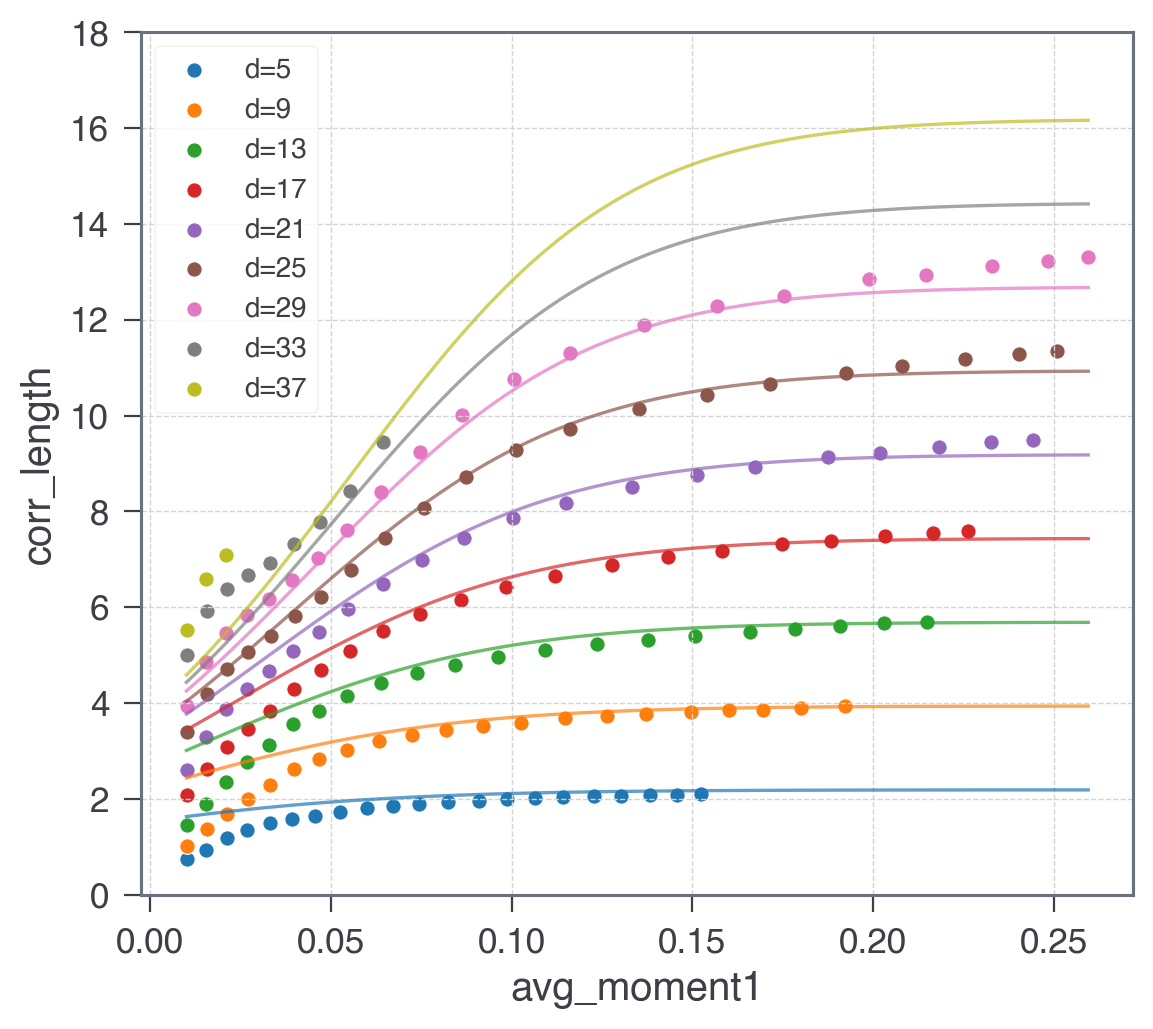

In [127]:
# Create p values for smooth fitted curves
p_smooth = np.linspace(0.01, df_cluster_stats["avg_moment1"].max(), 100)

draw_euclidean = True
draw_manhattan = False

for i_d, d in enumerate(dlist):
    try:
        df_d = df_cluster_stats.loc[d].reset_index()
        color = COLORS(i_d)

        # Plot scatter points
        if draw_euclidean:
            sns.scatterplot(
                df_d, x="avg_moment1", y="corr_length", color=color, label=f"d={d}"
            )
        if draw_manhattan:
            sns.scatterplot(
                df_d,
                x="avg_moment1",
                y="corr_length_manhattan",
                marker="x",
                color=color,
                label=f"d={d} (Manhattan)",
            )

        # Plot fitted curves if fitting was successful
        if draw_euclidean and popt_corr is not None:
            # Euclidean correlation length fit
            corr_fit = ansatz1([d, p_smooth], *popt_corr)
            plt.plot(p_smooth, corr_fit, color=color, linestyle="-", alpha=0.7)

        if draw_manhattan and popt_corr_manhattan is not None:
            # Manhattan correlation length fit
            corr_manhattan_fit = ansatz1([d, p_smooth], *popt_corr_manhattan)
            plt.plot(
                p_smooth, corr_manhattan_fit, color=color, linestyle="--", alpha=0.7
            )

    except:
        continue

# plt.xlim(0, 0.12)
y_max = np.floor(
    max(
        df_cluster_stats["corr_length"].max(),
        df_cluster_stats["corr_length_manhattan"].max(),
    )
    * 1.1
)
plt.ylim(0, y_max)
plt.legend(fontsize=10)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)

### Percolation threshold

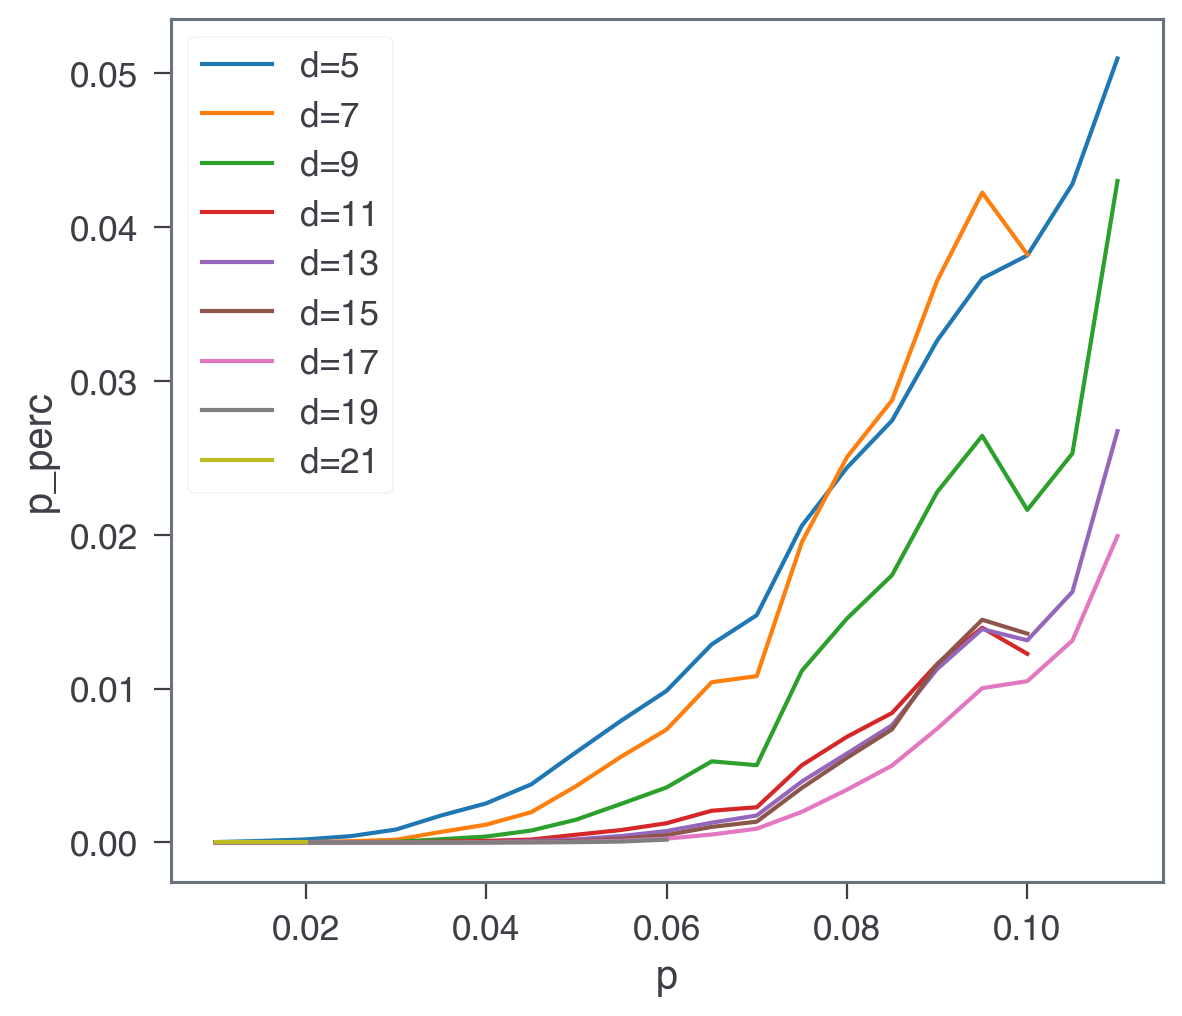

In [19]:
dlist = sorted(df_cluster_stats.index.get_level_values("d").unique())
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x="p",
        y="p_perc",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
plt.legend()

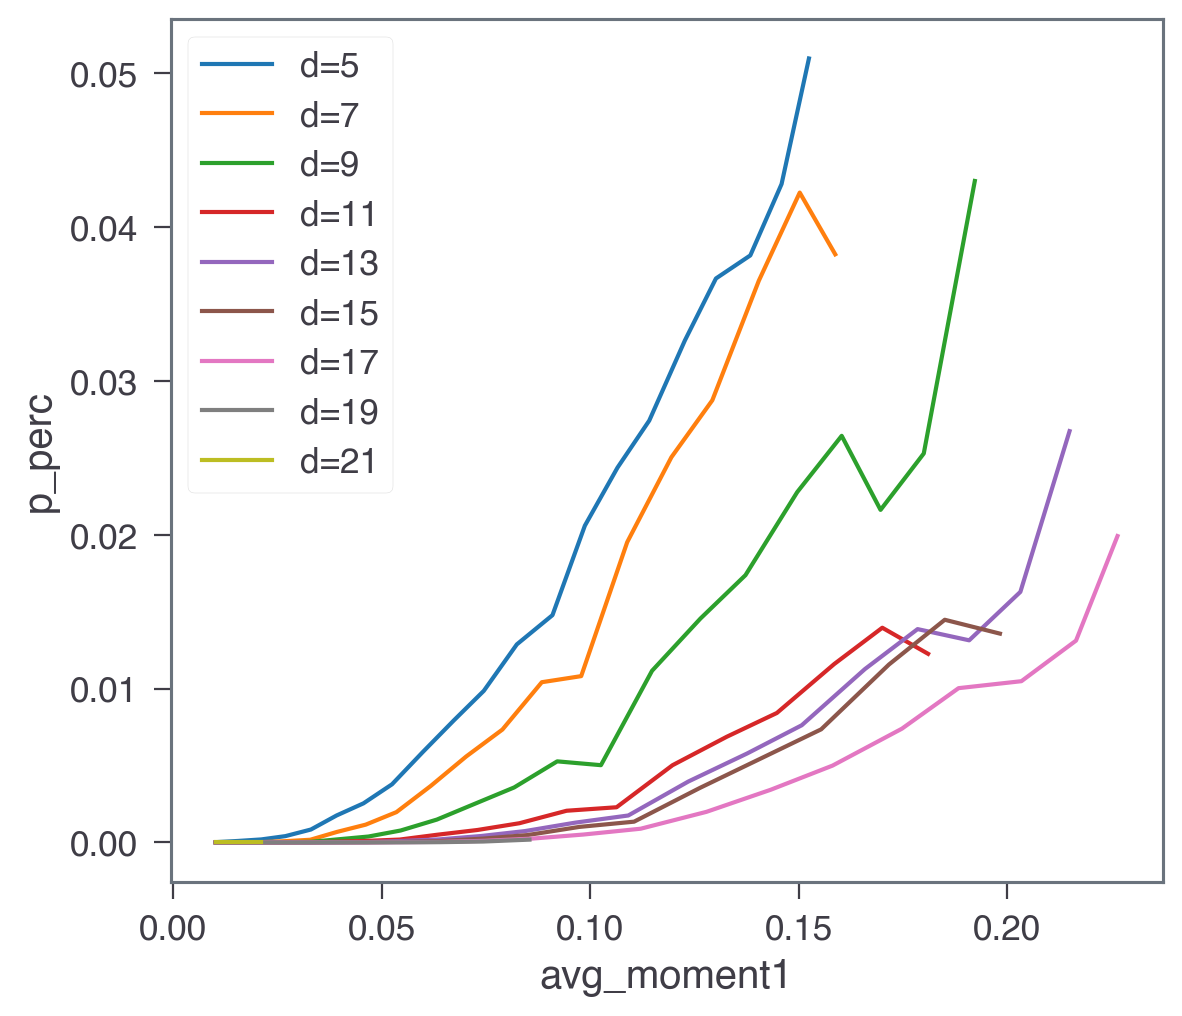

In [58]:
dlist = sorted(df_cluster_stats.index.get_level_values("d").unique())
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x="avg_moment1",
        y="p_perc",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
plt.legend()

### Moment 1

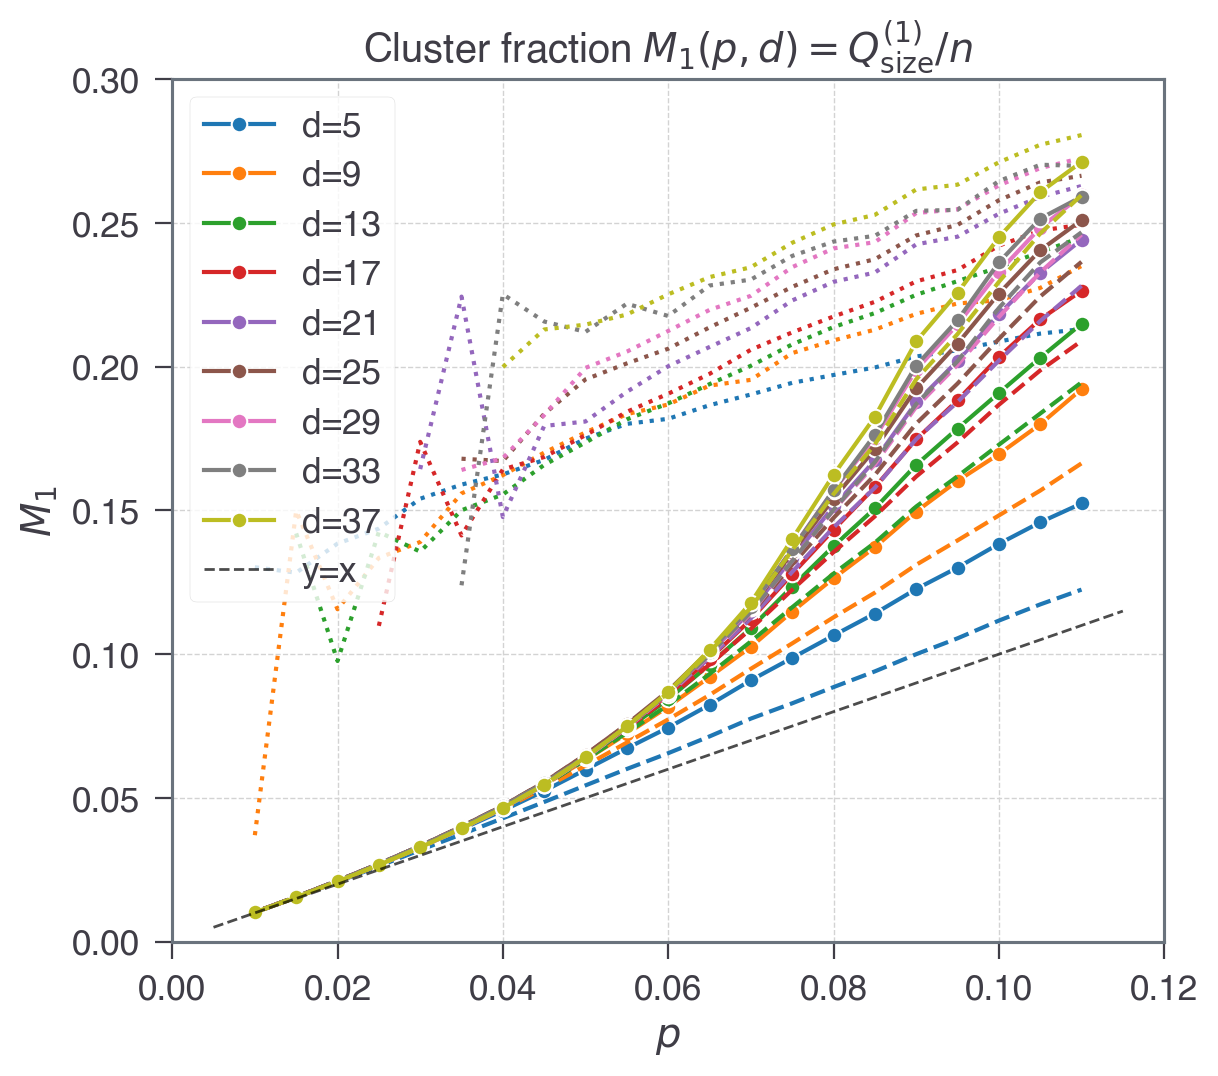

In [ ]:
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x="p",
        y="avg_moment1",
        marker="o",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x="p",
        y="avg_moment1_s",
        # marker="X",
        linestyle="--",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x="p",
        y="avg_moment1_f",
        # marker="X",
        linestyle=":",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )

# Add y=x reference line
x_min, x_max = plt.xlim()
plt.plot(
    [x_min, x_max],
    [x_min, x_max],
    color="black",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="y=x",
)

plt.title(r"Cluster fraction $M_1(p, d) = Q_\mathrm{size}^{(1)} / n$")
plt.xlabel(r"$p$")
plt.ylabel(r"$M_1$")
plt.xlim(0, 0.12)
plt.ylim(0, 0.3)
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.legend()

In [15]:
# Fit M1 = A * p + B * d^alpha
from scipy.optimize import curve_fit


moment1 = df_cluster_stats["avg_moment1"].values
p_all = df_cluster_stats.index.get_level_values("p").values
d_all = df_cluster_stats.index.get_level_values("d").values


def moment1_ansatz(params, A, alpha, beta):
    """
    Ansatz for first moment: log(M1) = A * p^{alpha * d + beta}
    """
    p, d = params
    return A + (alpha * d + beta) * np.log(p)


# Prepare data for fitting
params_data = (p_all, d_all)

# Initial guess for parameters [A, alpha, beta]
initial_guess = [2, 1, 0]

# Fit the model
y = np.log(moment1)
popt, pcov = curve_fit(moment1_ansatz, params_data, y, p0=initial_guess)
A_fit, alpha_fit, beta_fit = popt

print(f"Fitted parameters:")
print(f"A = {A_fit:.6f}")
print(f"alpha = {alpha_fit:.6f}")
print(f"beta = {beta_fit:.6f}")

Fitted parameters:
A = 1.136849
alpha = -0.002281
beta = 1.304771


### Moment 2

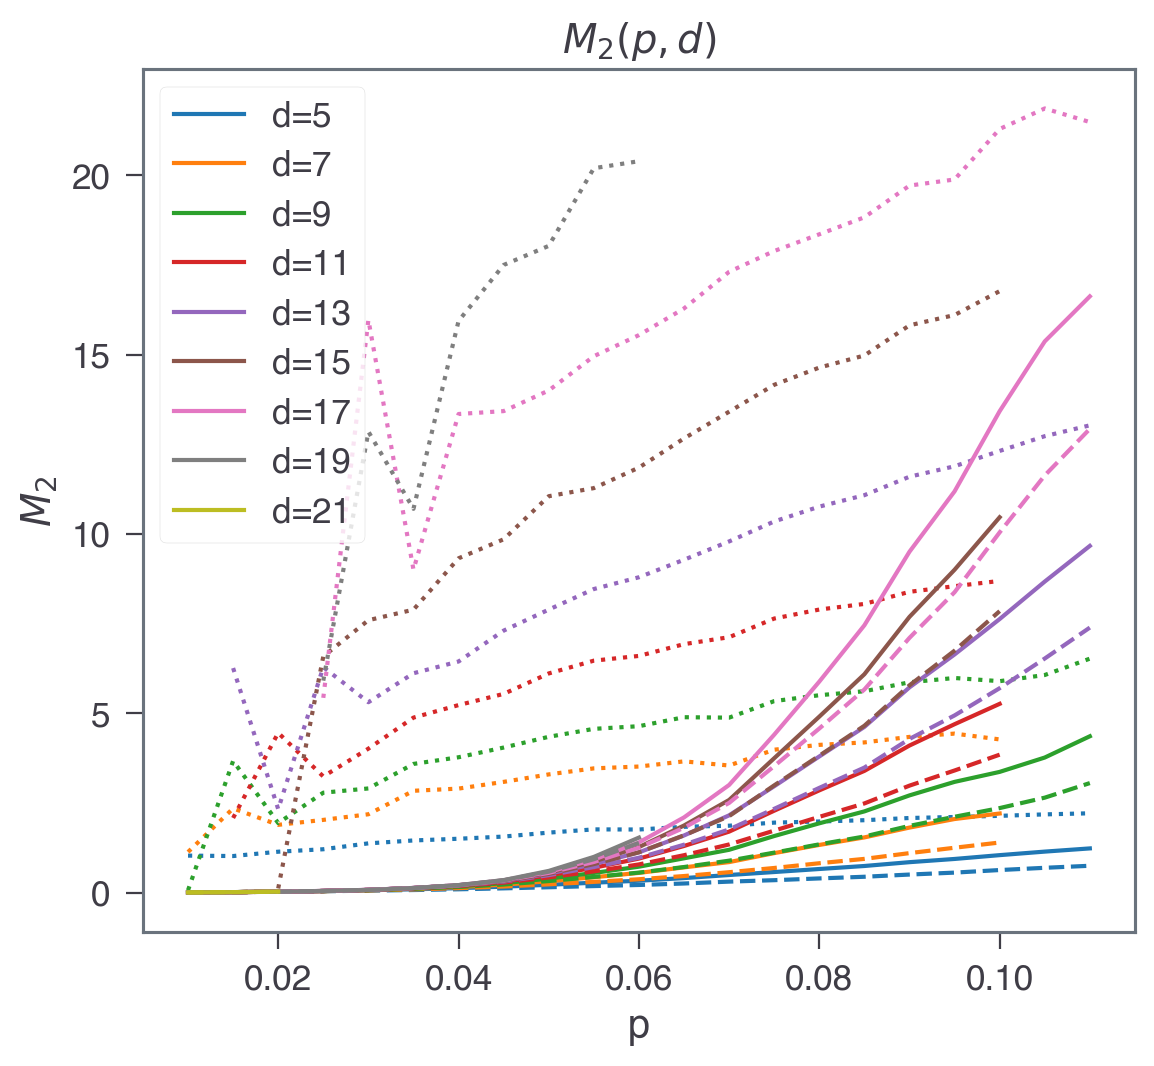

In [61]:
x = "p"
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2",
        # marker="o",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2_s",
        # marker="X",
        linestyle="--",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2_f",
        # marker="X",
        linestyle=":",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )

plt.title(r"$M_2(p, d)$")
plt.ylabel(r"$M_2$")
plt.legend()

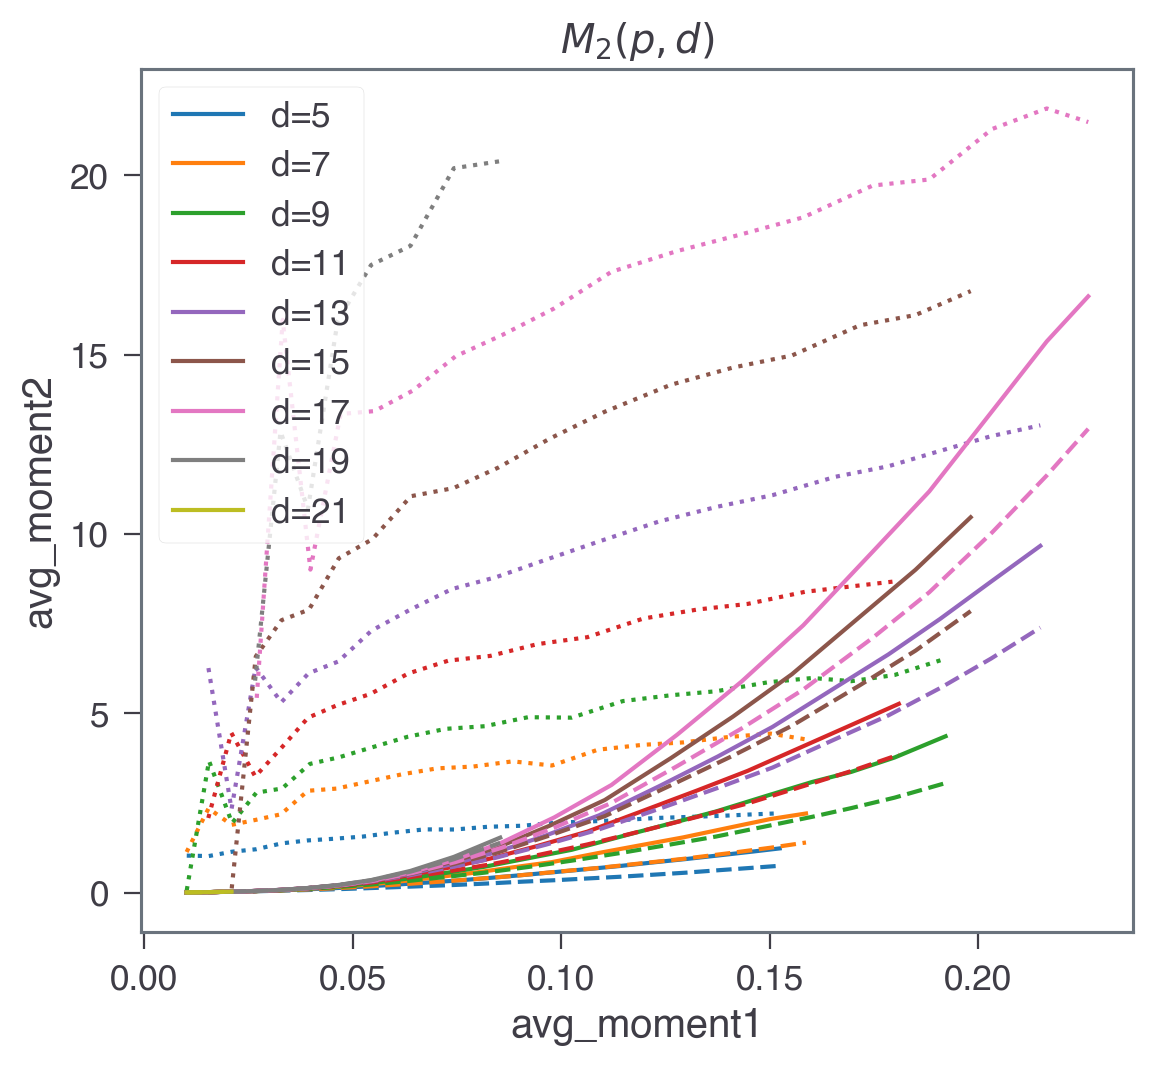

In [ ]:
x = "avg_moment1"
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2",
        # marker="o",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2_s",
        # marker="X",
        linestyle="--",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_moment2_f",
        # marker="X",
        linestyle=":",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )

plt.title(r"$M_2(p, d)$")
plt.legend()

### Average cluster size

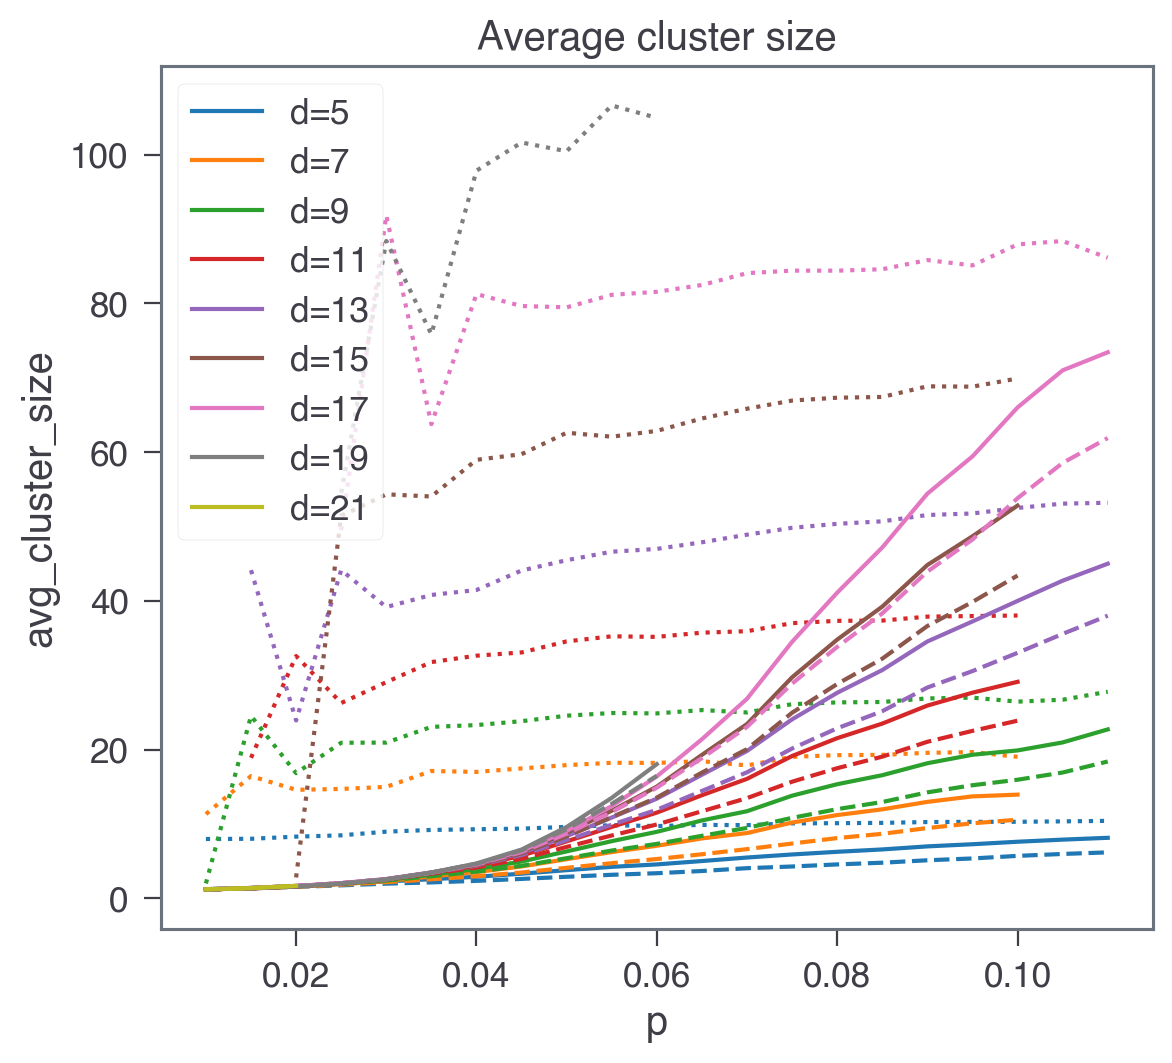

In [67]:
x = "p"
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size",
        # marker="o",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size_s",
        # marker="X",
        linestyle="--",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size_f",
        # marker="X",
        linestyle=":",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )

plt.title(r"Average cluster size")
plt.legend()

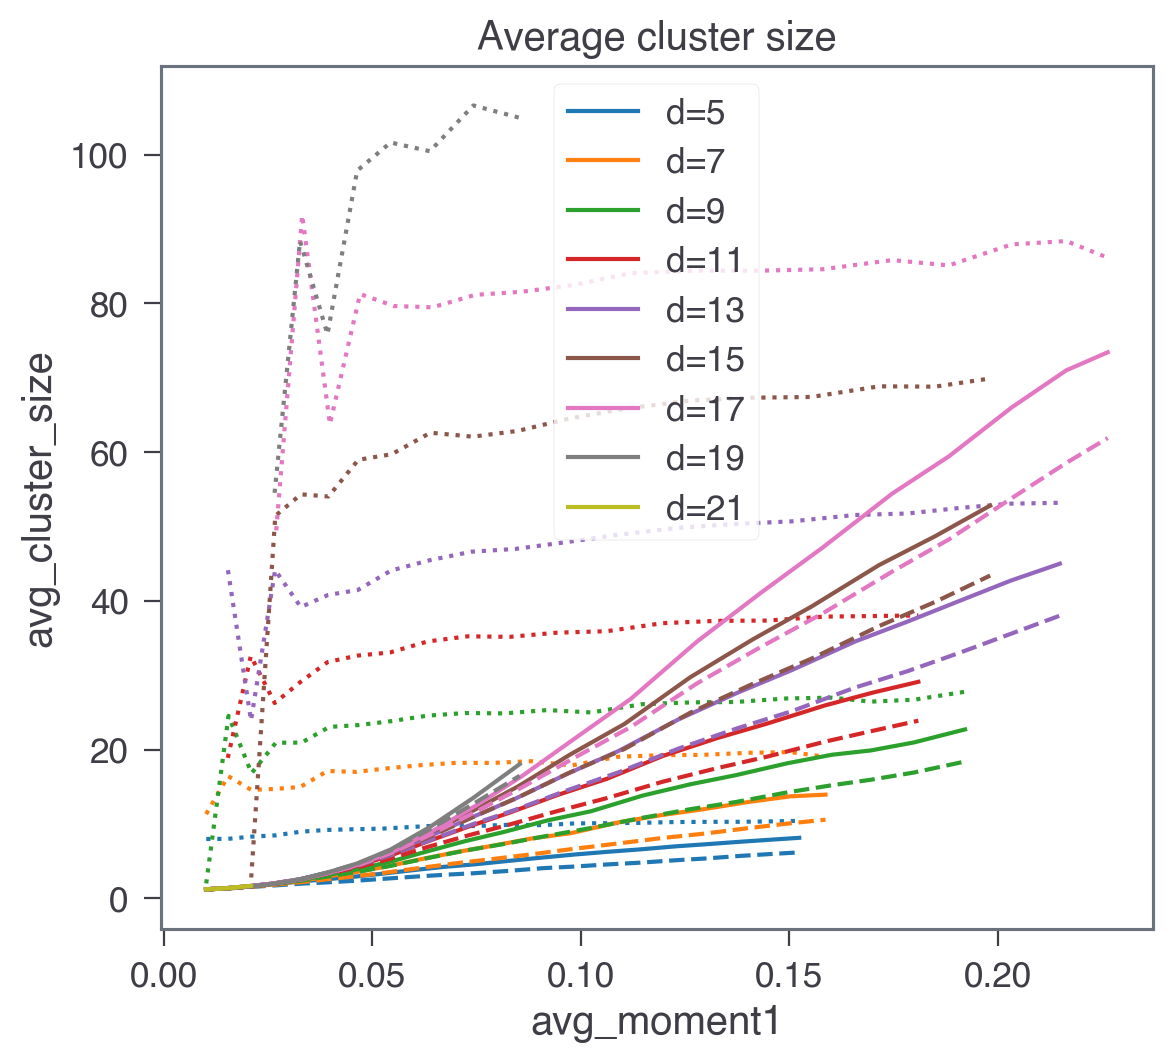

In [66]:
x = "avg_moment1"
for i_d, d in enumerate(dlist):
    df_d = df_cluster_stats.loc[d].reset_index()
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size",
        # marker="o",
        label=f"d={d}",
        linewidth=1.5,
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size_s",
        # marker="X",
        linestyle="--",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )
    sns.lineplot(
        df_d,
        x=x,
        y="avg_cluster_size_f",
        # marker="X",
        linestyle=":",
        linewidth=1.5,
        # label=f"d={d} (succ)",
        color=COLORS(i_d),
    )

plt.title(r"Average cluster size")
plt.legend()

### Ansatz fitting

In [82]:
# Finite size scaling ansatz fitting

from scipy.optimize import curve_fit


def finite_size_scaling_ansatz(
    params: tuple, alpha: float, A: float, B: float, C: float, p_c: float, nu: float
) -> np.ndarray:
    p, d = params
    x = (p - p_c) * d ** (1 / nu)
    return d**alpha * (A * x**2 + B * x + C)


def finite_size_scaling_ansatz_fixed_p_c(
    params: tuple, alpha: float, A: float, B: float, C: float, nu: float
) -> np.ndarray:
    p, d = params
    x = (p - 0.5) * d ** (1 / nu)
    return d**alpha * (A * x**2 + B * x + C)


def fit(
    rho: np.ndarray,
    d: np.ndarray,
    target: np.ndarray,
    initial_guess: list,
    rho_range: tuple | None = None,
    fixed_p_c: bool = False,
) -> tuple[np.ndarray, np.ndarray, float]:
    # Fit the ansatz
    if rho_range is not None:
        mask = (rho >= rho_range[0]) & (rho <= rho_range[1])
        rho = rho[mask]
        d = d[mask]
        target = target[mask]

    if fixed_p_c:
        function_to_fit = finite_size_scaling_ansatz_fixed_p_c
    else:
        function_to_fit = finite_size_scaling_ansatz

    popt, pcov = curve_fit(
        function_to_fit,
        (rho, d),
        target,
        p0=initial_guess,
    )

    param_errors = np.sqrt(np.diag(pcov))

    # Calculate R-squared
    y_pred = function_to_fit((rho, d), *popt)
    ss_res = np.sum((target - y_pred) ** 2)
    ss_tot = np.sum((target - np.mean(target)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return popt, param_errors, r_squared

In [79]:
# All samples

dlist = df_cluster_stats.index.get_level_values("d").values
# rho = df_cluster_sizes.index.get_level_values("p").values
rho = df_cluster_stats["avg_moment1"].values
# target = df_cluster_sizes["avg_moment2"].values
target = df_cluster_stats["avg_cluster_size"].values

p_c_guess = 0.1
initial_guess = [1.8, 1.0, 1.0, 1.0, 1.5]
# p_range = [p_c_guess / 2, np.inf]
rho_range = None

popt_all, param_errors_all, rsq = fit(
    rho, dlist, target, initial_guess, rho_range=rho_range, fixed_p_c=True
)
alpha_fit, A_fit, B_fit, C_fit, nu_fit = popt_all

print(f"R-squared = {rsq:.4f}")
print("Fitted parameters:")
print(f"alpha = {alpha_fit:.4f} ± {param_errors_all[0]:.4f}")
print(f"A = {A_fit:.4f} ± {param_errors_all[1]:.4f}")
print(f"B = {B_fit:.4f} ± {param_errors_all[2]:.4f}")
print(f"C = {C_fit:.4f} ± {param_errors_all[3]:.4f}")
# print(f"p_c = {p_c_fit:.4f} ± {param_errors_all[4]:.4f}")
print(f"nu = {nu_fit:.4f} ± {param_errors_all[4]:.4f}")

R-squared = 0.9913
Fitted parameters:
alpha = 1.4884 ± 0.0452
A = 8.4044 ± 1.4187
B = 12.1673 ± 1.7555
C = 4.2467 ± 0.5148
nu = 14.8693 ± 2.2880


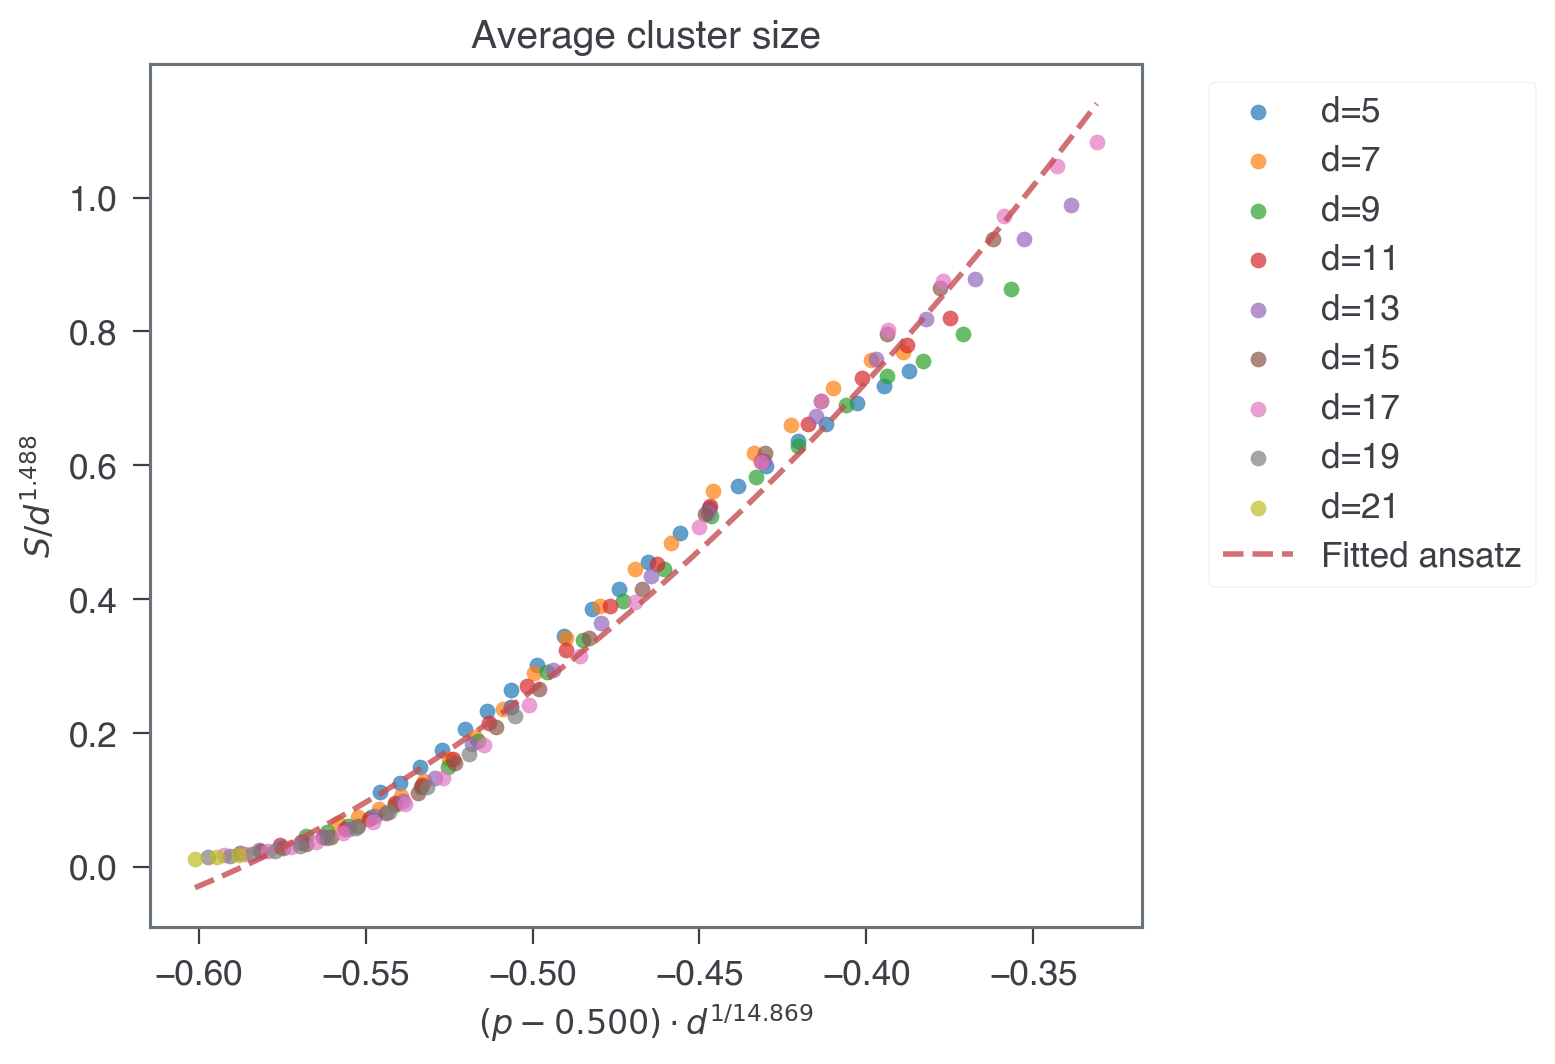

In [81]:
# Create the finite size scaling plot
alpha_fit, A_fit, B_fit, C_fit, nu_fit = popt_all
p_c = 0.5

# Calculate the scaled variables using fitted parameters
scaled_x = (rho - p_c) * (dlist ** (1 / nu_fit))
scaled_y = target / (dlist**alpha_fit)

# Create scatter plot with different colors for different distances
distances = np.unique(dlist)

for i, d in enumerate(distances):
    mask = dlist == d
    plt.scatter(
        scaled_x[mask],
        scaled_y[mask],
        color=COLORS(i),
        label=f"d={d}",
        alpha=0.7,
        s=30,
        marker="o",
    )

# Plot the theoretical curve using the fitted ansatz
x_theory = np.linspace(scaled_x.min(), scaled_x.max(), 200)
# For the theoretical curve, we need to evaluate the ansatz at a reference distance
# We'll use the scaling form: S/d^alpha = A*x^2 + B*x + C where x = (p-p_c)*d^(1/nu)
y_theory = A_fit * x_theory**2 + B_fit * x_theory + C_fit
plt.plot(x_theory, y_theory, "r--", linewidth=2, label="Fitted ansatz", alpha=0.8)

plt.xlabel(rf"$(p - {p_c:.3f}) \cdot d^{{1/{nu_fit:.3f}}}$", fontsize=12)
plt.ylabel(rf"$S / d^{{{alpha_fit:.3f}}}$", fontsize=12)
plt.title(f"Average cluster size", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

### Post-selection

In [13]:
df_cluster_stats.head()

p_fail  avg_moment1  avg_moment1_f  avg_moment1_s  avg_moment2  \
d p                                                                         
5 0.010  0.000267     0.010242       0.130262       0.010210     0.012574   
  0.015  0.000979     0.015535       0.128355       0.015425     0.021471   
  0.020  0.002497     0.021102       0.138478       0.020808     0.034639   
  0.025  0.005259     0.026880       0.143693       0.026263     0.051859   
  0.030  0.009244     0.033009       0.154083       0.031879     0.074922   

         avg_moment2_f  avg_moment2_s  avg_cluster_size  avg_cluster_size_f  \
d p                                                                           
5 0.010       1.038876       0.012300          1.227685            7.975273   
  0.015       1.027028       0.020486          1.382108            8.001432   
  0.020       1.148010       0.031852          1.641486            8.290185   
  0.025       1.216558       0.045701          1.929249            8.466388   
  0.030       1.380772       0.062738          2.269722            8.961245   

         avg_cluster_size_s  corr_length  corr_length_f  corr_length_s  
d p                                                                     
5 0.010            1.204694     0.735265       2.032504       0.677955  
  0.015            1.328130     0.937714       2.041531       0.847199  
  0.020            1.530725     1.172851       2.069641       1.055095  
  0.025            1.740155     1.344096       2.083455       1.204137  
  0.030            1.967963     1.486155       2.101220       1.324978

In [19]:
sample_stats[5][0.01].head()

fail  moment_1  moment_2  max_cluster_size  corr_length  \
0  False      0.00      0.00                 0          0.0   
1  False      0.00      0.00                 0          0.0   
2  False      0.04      0.04                 1          0.0   
3  False      0.00      0.00                 0          0.0   
4  False      0.00      0.00                 0          0.0   

   corr_length_manhattan  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm

num_bins = 10000
dfs_agg = {}

for d, p in tqdm(df_cluster_stats.index):
    df_samples = sample_stats[d][p]

    # Initialize dictionary for this (d, p) pair
    if (d, p) not in dfs_agg:
        dfs_agg[(d, p)] = {}

    # Process each column except 'fail'
    for col in df_samples.columns:
        if col == "fail":
            continue

        # Get column data
        col_data = df_samples[col].values

        # Calculate min and max values
        min_val = np.min(col_data)
        max_val = np.max(col_data)

        # Create uniform bins
        bin_edges = np.linspace(min_val, max_val, num_bins + 1)

        # Calculate histogram for all samples
        total_counts, _ = np.histogram(col_data, bins=bin_edges)

        # Calculate histogram for failed samples only
        fail_mask = df_samples["fail"].values
        fail_data = col_data[fail_mask]
        fail_counts, _ = np.histogram(fail_data, bins=bin_edges)

        # Create dataframe with bin upper bounds as index
        bin_upper_bounds = bin_edges[1:]  # Upper bounds of each bin
        df_hist = pd.DataFrame(
            {"count": total_counts, "num_fails": fail_counts}, index=bin_upper_bounds
        )

        # Store in dictionary
        dfs_agg[(d, p)][col] = df_hist

100%|██████████| 189/189 [00:18<00:00, 10.42it/s]


In [21]:
dfs_agg[(5, 0.1)]["moment_1"].head()

count  num_fails
0.0001   5210          2
0.0002      0          0
0.0003      0          0
0.0004      0          0
0.0005      0          0

In [50]:
from statsmodels.stats.proportion import proportion_confint

# Create cumulative sum dictionary with confidence intervals
dfs_ps = {}

for (d, p), col_dict in tqdm(list(dfs_agg.items())):
    # Initialize dictionary for this (d, p) pair
    dfs_ps[(d, p)] = {}

    for col, df_hist in col_dict.items():
        # Calculate cumulative sums from the end (reverse cumsum)
        cumsum_count = df_hist["count"].cumsum()
        cumsum_fails = df_hist["num_fails"].cumsum()

        # Filter out rows where cumsum_count is zero
        nonzero_mask = cumsum_count > 0
        filtered_count = cumsum_count[nonzero_mask]
        filtered_fails = cumsum_fails[nonzero_mask]

        # Calculate confidence intervals for failure probability using vectorized operations
        lower_bounds, upper_bounds = proportion_confint(
            filtered_fails.values, filtered_count.values, method="wilson"
        )

        # Calculate failure probabilities and uncertainties
        p_fails = (upper_bounds + lower_bounds) / 2
        delta_pfails = upper_bounds - p_fails

        # Calculate total counts for p_abort calculation
        total_count = cumsum_count.values[-1]

        # Calculate confidence intervals for abort probability using vectorized operations
        abort_lower_bounds, abort_upper_bounds = proportion_confint(
            total_count - cumsum_count.values, total_count, method="wilson"
        )

        # Calculate abort probabilities and uncertainties
        p_aborts = (abort_upper_bounds + abort_lower_bounds) / 2
        delta_p_aborts = abort_upper_bounds - p_aborts

        # Create dataframe with cumulative statistics and confidence intervals
        df_cumsum = pd.DataFrame(
            {
                "count": filtered_count,
                "num_fails": filtered_fails,
                "p_fail": p_fails,
                "delta_p_fail": delta_pfails,
                "p_abort": p_aborts,
                "delta_p_abort": delta_p_aborts,
            },
            index=filtered_count.index,
        )

        # Store in dictionary
        dfs_ps[(d, p)][col] = df_cumsum

100%|██████████| 189/189 [00:00<00:00, 262.57it/s]


In [51]:
dfs_ps[(5, 0.01)]["moment_1"].head()

count  num_fails    p_fail  delta_p_fail   p_abort  delta_p_abort
0.000044  604282          0  0.000003      0.000003  0.395718       0.000958
0.000088  604282          0  0.000003      0.000003  0.395718       0.000958
0.000132  604282          0  0.000003      0.000003  0.395718       0.000958
0.000176  604282          0  0.000003      0.000003  0.395718       0.000958
0.000220  604282          0  0.000003      0.000003  0.395718       0.000958

/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_37023/3282476744.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


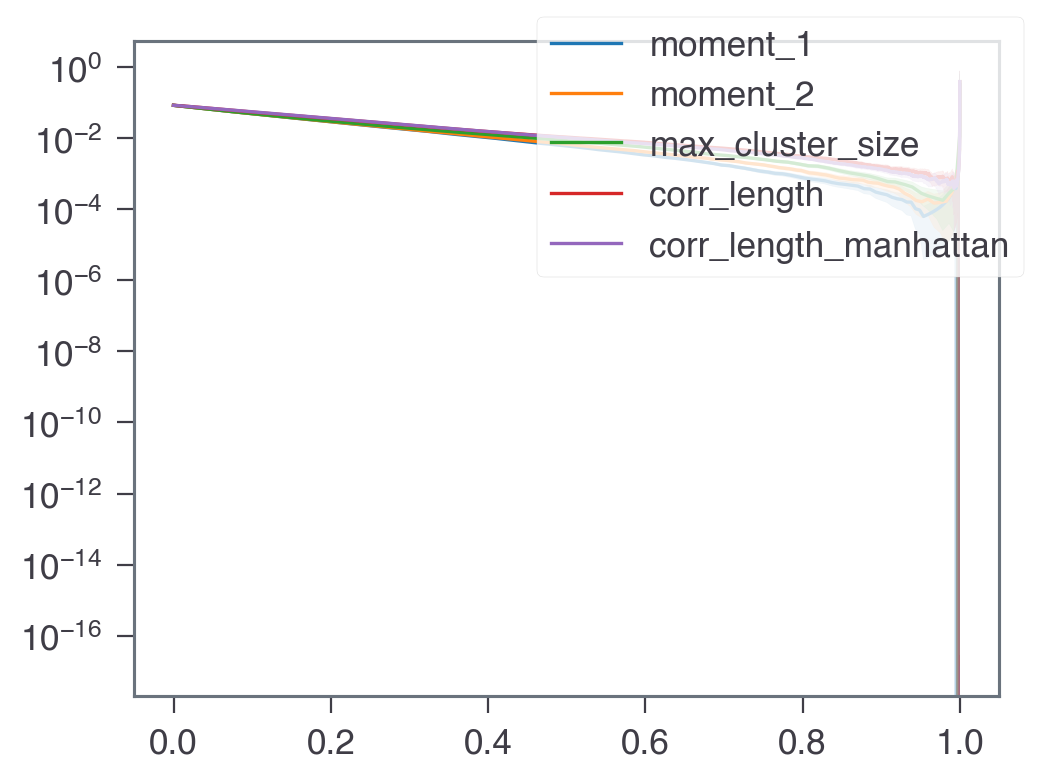

In [ ]:
from simulations.analysis.plotting_helpers import error_band_plot


def plot_p_abort_vs_p_fail(d, p):
    fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

    # Get available columns for this (d, p) combination
    available_cols = list(dfs_ps[(d, p)].keys())

    # Plot each column as a different colored line
    for i, col in enumerate(available_cols):
        df = dfs_ps[(d, p)][col]
        df = df.sort_values(by="p_abort")

        error_band_plot(
            df["p_abort"],
            df["p_fail"],
            df["delta_p_fail"],
            ax=ax,
            color=COLORS(i),
            label=col,
        )

    ax.set_yscale("log")
    fig.legend()
    fig.tight_layout()
    fig.show()


plot_p_abort_vs_p_fail(21, 0.08)

In [70]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

def get_df_hist(d, p, col, num_bins):
    df_samples = sample_stats[d][p]

    # Initialize dictionary for this (d, p) pair
    if (d, p) not in dfs_agg:
        dfs_agg[(d, p)] = {}

    # Get column data
    col_data = df_samples[col].values

    # Calculate min and max values
    min_val = np.min(col_data)
    max_val = np.max(col_data)

    # Create uniform bins
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    # Calculate histogram for all samples
    total_counts, _ = np.histogram(col_data, bins=bin_edges)

    # Calculate histogram for failed samples only
    fail_mask = df_samples["fail"].values
    fail_data = col_data[fail_mask]
    fail_counts, _ = np.histogram(fail_data, bins=bin_edges)

    # Calculate p_fail
    pfail_lower, pfail_upper = proportion_confint(
        fail_counts, total_counts, method="wilson"
    )
    pfail = (pfail_lower + pfail_upper) / 2
    delta_pfail = pfail_upper - pfail

    # Create dataframe with bin upper bounds as index
    bin_upper_bounds = bin_edges[1:]  # Upper bounds of each bin
    df_hist = pd.DataFrame(
        {
            "count": total_counts,
            "num_fails": fail_counts,
            "p_fail": pfail,
            "delta_p_fail": delta_pfail,
        },
        index=bin_upper_bounds,
    )

    return df_hist

/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)


(0.0, 0.5)

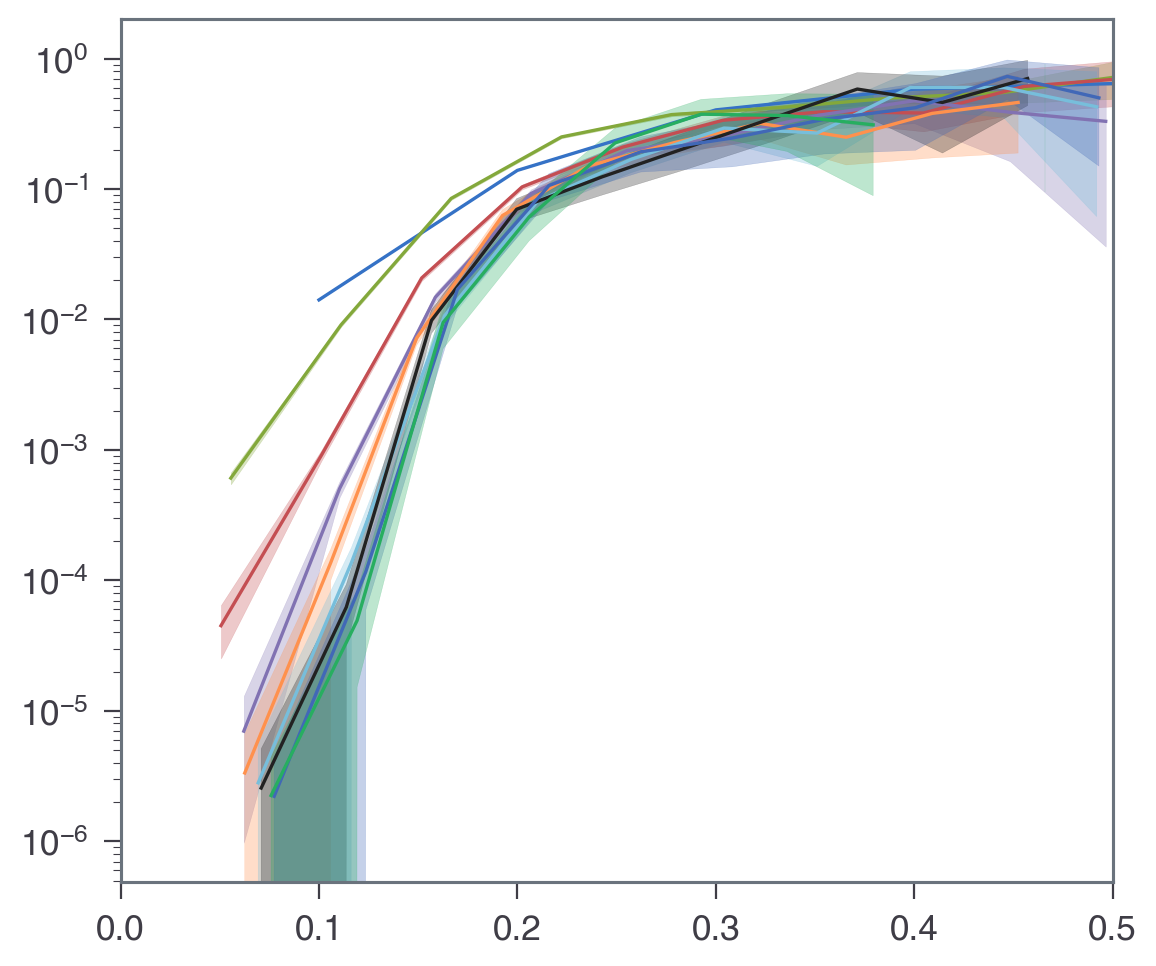

In [76]:
for d in dlist:
    df_hist = get_df_hist(d, 0.05, "moment_1", 10)
    error_band_plot(df_hist.index, df_hist['p_fail'], df_hist['delta_p_fail'])
plt.yscale('log')
plt.xlim(0, 0.5)